In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.distributions import Categorical

In [343]:
grnd = np.zeros((10,10))

In [47]:
# np.indices((10,10))

In [48]:
walls_i = np.random.choice(10,(20))
walls_j = np.random.choice(10,(20))

In [49]:
grnd[walls_i,walls_j] = 1

In [50]:
grnd.sum()

19.0

In [51]:
prev_grnd = grnd.copy()

In [57]:
np.stack(grnd.nonzero())[:,0]

array([0, 9])

In [58]:
current_pos = np.stack(grnd.nonzero())[:,0]

In [59]:
current_pos

array([0, 9])

In [344]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(16,50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50,100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100,32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32,5)
        self.fc5 = nn.Linear(32,1)
        self.tanh1 = nn.Tanh()
        self.fc6 = nn.Linear(32,1)
        self.tanh2 = nn.Tanh()
        
    def forward(self,x):
        out = torch.FloatTensor(x).view(1,-1)
        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.relu3(self.fc3(out))
        sell_rate = self.tanh1(self.fc5(out))
        purchase_rate = self.tanh2(self.fc6(out))
        out = self.fc4(out)
        return out,sell_rate,purchase_rate

In [243]:
class Entity:
    def __init__(self):
        self.food = 100 #Kg
        self.money = 100.0 #Rs
        self.life = 100.0 #years
        self.hunger = 0
#         self.walk_dist_capacity = 10 #Km
        self.brain = Net()
        
        #memory of past 10 actions
        self.memory = np.zeros(10)
        self.mem_cntr = 0
        self.alive = True
        
        #rates
        self.sell_rate = 1
        self.purchase_rate = 1
        
    def action(self,partner_sr=1,partner_pr=1):
        state = np.append(np.array([self.food,self.money,self.life,self.hunger,partner_sr,partner_pr]),self.memory)
#         print('state',state)
        decisions_array,sr,pr = self.brain(state)
#         print('sr,pr',sr,pr)
#         print('decisions_array',decisions_array)
        m = Categorical(torch.softmax(decisions_array,1))
        decision = m.sample().item()
#         decision = decisions_array.argmax()
        
#         print('decision',decision)
        mem_indx = self.mem_cntr
        self.memory = np.append(self.memory,decision)[1:]
#         print('self.memory',self.memory)
        self.mem_cntr += 1
        
        actions = {0:self.eat,1:self.walk,2:self.sell,3:self.purchase,4:self.decide_rates}
        print(actions[decision].__name__)
        if decision == 4:
            actions[decision](sr,pr)
        else:
            actions[decision]()
    
    def eat(self):
        if self.food > 0:
            self.food = max(self.food-1,0)
            self.hunger = max(self.hunger-5,0)
        self.life -= 0.5
        if self.life <= 0:
            self.alive = False
    
    def walk(self):
        self.hunger += 1
        self.life -= 0.5
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
    
    def sell(self):
        self.food -= 1
        self.money += 1 * self.sell_rate
        self.hunger += 1
        self.life -= 0.5
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
    
    def purchase(self):
        self.food += 1
        self.money -= 1 * self.purchase_rate
        self.hunger += 1
        self.life -= 0.5
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
            
    def decide_rates(self,sr,pr):
        self.hunger += 1
        self.life -= 0.5
        self.sell_rate = 1+sr.item()
        self.purchase_rate = 1+pr.item()
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False

In [233]:
entity = Entity()

In [234]:
entity.action()

In [235]:
entity.sell_rate

1

In [236]:
entity.purchase_rate

1

In [202]:
{i:j for i,j in vars(entity).items() if (i != 'brain') & (i != 'memory')}

{'alive': True,
 'food': 102,
 'hunger': 6,
 'life': 96.0,
 'mem_cntr': 8,
 'money': 97.0,
 'purchase_rate': 0.002884507179260254,
 'sell_rate': 1.2657804191112518}

In [247]:
entity = Entity()
cntr = 0
while entity.alive:
    print('**************************',cntr,'******************************')
    entity.action()
    print({i:j for i,j in vars(entity).items() if (i != 'brain') & (i != 'memory')})
    cntr += 1

************************** 0 ******************************
decide_rates
{'food': 100, 'money': 100.0, 'life': 99.5, 'hunger': 1, 'mem_cntr': 1, 'alive': True, 'sell_rate': 0.5170462131500244, 'purchase_rate': 1.3529401123523712}
************************** 1 ******************************
walk
{'food': 100, 'money': 100.0, 'life': 99.0, 'hunger': 2, 'mem_cntr': 2, 'alive': True, 'sell_rate': 0.5170462131500244, 'purchase_rate': 1.3529401123523712}
************************** 2 ******************************
eat
{'food': 99, 'money': 100.0, 'life': 98.5, 'hunger': 0, 'mem_cntr': 3, 'alive': True, 'sell_rate': 0.5170462131500244, 'purchase_rate': 1.3529401123523712}
************************** 3 ******************************
eat
{'food': 98, 'money': 100.0, 'life': 98.0, 'hunger': 0, 'mem_cntr': 4, 'alive': True, 'sell_rate': 0.5170462131500244, 'purchase_rate': 1.3529401123523712}
************************** 4 ******************************
walk
{'food': 98, 'money': 100.0, 'life': 97.5, 

In [51]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.fc1 = nn.Linear(36,50)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(50,100)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(100,32)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(32,4)
#         self.fc5 = nn.Linear(32,1)
#         self.tanh1 = nn.Tanh()
#         self.fc6 = nn.Linear(32,1)
#         self.tanh2 = nn.Tanh()
        self.fc7 = nn.Linear(32,2)
#         self.sigmoid1 = nn.Sigmoid()
        self.fc8 = nn.Linear(32,2)
#         self.sigmoid2 = nn.Sigmoid()
        
    def forward(self,x):
        out = torch.FloatTensor(x).view(1,-1)
        out = self.relu1(self.fc1(out))
        out = self.relu2(self.fc2(out))
        out = self.relu3(self.fc3(out))
#         sell_rate = self.tanh1(self.fc5(out))
#         purchase_rate = self.tanh2(self.fc6(out))
        open_for_sell = self.fc7(out)
        open_for_purchase = self.fc8(out)
        out = self.fc4(out)
        return out,open_for_sell,open_for_purchase

In [52]:
# class Entity:
#     def __init__(self):
#         self.food = 100 #Kg
#         self.money = 100.0 #Rs
#         self.life = 100.0 #years
#         self.hunger = 0
#         self.brain = Net()
        
#         #memory of past 10 actions
#         self.memory = np.zeros(10)
#         self.mem_cntr = 0
#         self.alive = True
        
#         #rates
#         self.sell_rate = 1
#         self.purchase_rate = 1
        
#         #business availability
#         self.open_for_sell = False
#         self.open_for_purchase = False
        
#     def action(self,partner_sr=1,partner_pr=1,partner_os=False,partner_op=False):
#         state = np.append(np.array([self.food,self.money,self.life,self.hunger,partner_sr,partner_pr,int(partner_os),int(partner_os)]),self.memory)
#         decisions_array,sr,pr,os,op = self.brain(state)
#         self.open_for_sell = False if os.item() < 0.5 else True
#         self.open_for_purchase = False if op.item() < 0.5 else True
#         self.sell_rate = 1+sr.item()
#         self.purchase_rate = 1+pr.item()
#         m = Categorical(torch.softmax(decisions_array,1))
#         decision = m.sample().item()
#         mem_indx = self.mem_cntr
#         self.memory = np.append(self.memory,decision)[1:]
#         self.mem_cntr += 1
        
#         actions = {0:self.eat,1:self.walk,2:self.sell,3:self.purchase}
#         print(actions[decision].__name__)
#         if decision == 2:
#             actions[decision](partner_op,partner_pr)
#         elif decision == 3:
#             actions[decision](partner_os,partner_sr)
#         else:
#             actions[decision]()
    
#     def eat(self):
#         if self.food > 0:
#             self.food = max(self.food-1,0)
#             self.hunger = max(self.hunger-3,0)
#         else:
#             self.hunger += 1
#         self.life -= 1
#         if self.life <= 0:
#             self.alive = False
    
#     def walk(self):
#         self.hunger += 1
#         self.life -= 1
#         if (self.hunger >= 10) | (self.life <= 0):
#             self.alive = False
    
#     def sell(self,partner_op,partner_pr):
#         if partner_op:
#             self.food -= 1
#             self.money += 1 * (self.sell_rate*partner_pr)/2
#         self.hunger += 1
#         self.life -= 1
#         if (self.hunger >= 10) | (self.life <= 0):
#             self.alive = False
    
#     def purchase(self,partner_os,partner_sr):
#         if partner_os:
#             self.food += 1
#             self.money -= 1 * (self.purchase_rate*partner_sr)/2
#         self.hunger += 1
#         self.life -= 1
#         if (self.hunger >= 10) | (self.life <= 0):
#             self.alive = False

In [257]:
class Entity:
    def __init__(self):
        self.food = 100 #Kg
        self.money = 100.0 #Rs
        self.life = 100.0 #years
        self.hunger = 0
        self.brain = Net()
        self.gamma = 0.9
        self.optimizer = optim.Adam(params=self.brain.parameters(),lr=1e-3)
        self.reward = 0
        self.baseline = 50
        self.life_decisions = []
        self.all_rews = []
        
        #memory of past 10 actions
        self.memory = np.zeros(30)
        self.mem_cntr = 0
        self.alive = True
        
        #logits collected
        self.decisions_logits = []
        self.open_for_sell_logits = []
        self.open_for_purchase_logits = []
        
        #rates
        self.sell_rate = 1
        self.purchase_rate = 1
        
        #business availability
        self.open_for_sell = False
        self.open_for_purchase = False
        
    def action(self,partner):
        partner_sr,partner_pr,partner_os,partner_op = partner.sell_rate,partner.purchase_rate,partner.open_for_sell,partner.open_for_purchase
#         state = np.append(np.array([self.food,self.money,self.life,self.hunger,partner_sr,partner_pr,int(partner_os),int(partner_op)]),self.memory)
        state = np.append(np.array([self.food,self.money,self.life,self.hunger,int(partner_os),int(partner_op)]),self.memory)
        decisions_array,os,op = self.brain(state)
#         self.open_for_sell = False if os.item() < 0.5 else True
#         self.open_for_purchase = False if op.item() < 0.5 else True
        
        
        m = Categorical(torch.softmax(os,1))
        sampled = m.sample()
        self.open_for_sell_logits.append(m.log_prob(sampled))
        self.open_for_sell = sampled.bool().item()

        m = Categorical(torch.softmax(op,1))
        sampled = m.sample()
        self.open_for_purchase_logits.append(m.log_prob(sampled))
        self.open_for_purchase = sampled.bool().item()

#         self.sell_rate = 1+sr.item()
#         self.purchase_rate = 1+pr.item()
        self.sell_rate = 1
        self.purchase_rate = 1
        m = Categorical(torch.softmax(decisions_array,1))
        sampled = m.sample()
        self.decisions_logits.append(m.log_prob(sampled))
        decision = sampled.item()
        mem_indx = self.mem_cntr
        self.memory = np.append(self.memory,[decision,self.open_for_sell,self.open_for_purchase])[3:]
        self.mem_cntr += 1
        
        actions = {0:self.eat,1:self.walk,2:self.sell,3:self.purchase}
        self.life_decisions.append(actions[decision].__name__)
#         print(actions[decision].__name__)
        if (decision == 2) | (decision == 3):
            actions[decision](partner)
        else:
            actions[decision]()
    
    def eat(self):
        if self.food > 0:
            self.food = max(self.food-1,0)
            self.hunger = max(self.hunger-3,0)
        else:
            self.hunger += 1
        self.life -= 1
        if self.life <= 0:
            self.alive = False
    
    def walk(self):
        self.hunger += 1
        self.life -= 1
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
    
    def sell(self,partner):
        partner_op = partner.open_for_purchase
        if partner_op:
            self.food -= 1
            self.money += 1 * self.sell_rate
            partner.food += 1
            partner.money -= 1 * self.sell_rate
            
        self.hunger += 1
        self.life -= 1
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
    
    def purchase(self,partner):
        partner_os = partner.open_for_sell
#         print('partner.open_for_sell',partner.open_for_sell)
        if partner_os:
            self.food += 1
            self.money -= 1 * self.purchase_rate
            partner.food -= 1
            partner.money += 1 * self.purchase_rate
            
        self.hunger += 1
        self.life -= 1
        if (self.hunger >= 10) | (self.life <= 0):
            self.alive = False
            
            
    def get_discounted_scaled_rewards(self):
        rewards = [self.reward * self.gamma**i for i in range(100)]
        rewards = list(reversed(rewards))
        rewards = torch.FloatTensor(rewards)
        rewards = (rewards - rewards.min())/((rewards - rewards.min())).max()
        return rewards
            
    def learn(self):
        
#         print('health x wealth',self.money*self.mem_cntr)
        
        self.reward = (self.money*self.mem_cntr)/(self.money+self.mem_cntr) - self.baseline
        discounted_rewards = self.get_discounted_rewards()
        self.all_rews.append(self.reward)
        
        decision_states = torch.stack(self.decisions_logits)
        os_states = torch.stack(self.open_for_sell_logits)
        op_states = torch.stack(self.open_for_purchase_logits)
        
        self.decisions_logits = []
        self.open_for_sell_logits = []
        self.open_for_purchase_logits = []
        self.life_decisions = []
        
        loss_decision = -(decision_states) * discounted_rewards
        loss_os = -(os_states) * discounted_rewards
        loss_op = -(op_states) * discounted_rewards
        
        loss = loss_decision.mean() + loss_os.mean() + loss_op.mean()
        
#         print('loss',loss)
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        self.food = 100 #Kg
        self.money = 100.0 #Rs
        self.life = 100.0 #years
        self.hunger = 0
        
        self.memory = np.zeros(30)
        self.mem_cntr = 0
        self.alive = True
        
        #rates
        self.sell_rate = 1
        self.purchase_rate = 1
        
        #business availability
        self.open_for_sell = False
        self.open_for_purchase = False

In [323]:
t = torch.FloatTensor([2,3,-1,0.9,0.24,4,3])

In [324]:
t

tensor([ 2.0000,  3.0000, -1.0000,  0.9000,  0.2400,  4.0000,  3.0000])

In [329]:
(t - t.min())/(t - t.min()).max()

tensor([0.0000, 0.3270, 0.3088, 0.6283, 0.0018, 0.4906, 1.0000])

In [193]:
# entity = Entity()
# cntr = 0
# while entity.alive:
#     print('**************************',cntr,'******************************')
#     entity.action(partner=Entity())
#     print({i:j for i,j in vars(entity).items() if (i != 'brain') & (i != 'memory')})
#     cntr += 1

In [251]:
people = """Liam
Noah
Oliver
William
Elijah
James
Benjamin
Lucas
Mason
Ethan
Alexander
Henry
Jacob
Michael
Daniel
Logan
Jackson
Sebastian
Jack
Aiden
Owen
Samuel
Matthew
Joseph
Levi
Mateo
David
John
Wyatt
Carter
Julian
Luke
Grayson
Isaac
Jayden
Theodore
Gabriel
Anthony
Dylan
Leo
Lincoln
Jaxon
Asher
Christopher
Josiah
Andrew
Thomas
Joshua
Ezra
Hudson
Charles
Caleb
Isaiah
Ryan
Nathan
Adrian
Christian
Maverick
Colton
Elias
Aaron
Eli
Landon
Jonathan
Nolan
Hunter
Cameron
Connor
Santiago
Jeremiah
Ezekiel
Angel
Roman
Easton
Miles
Robert
Jameson
Nicholas
Greyson
Cooper
Ian
Carson
Axel
Jaxson
Dominic
Leonardo
Luca
Austin
Jordan
Adam
Xavier
Jose
Jace
Everett
Declan
Evan
Kayden
Parker
Wesley
Kai"""

In [252]:
people = people.split('\n')

In [262]:
import time

In [293]:
population = {i:Entity() for i in people}
np.random.shuffle(people)
pairs = list(zip(people[:50],people[50:]))

#action = interact
gens_rew = []
pop_rews = {i:[] for i in people}
for k in range(100):
    if k % 1000 == 0:
        print('**************',k,'****************')
    pop_rew = []
    for i,j in pairs:
        entity_1 = population[i]
        entity_2 = population[j]

#         print(i,{l:m for l,m in vars(entity_1).items() if (l != 'brain') & (l != 'memory')})
#         print(j,{l:m for l,m in vars(entity_2).items() if (l != 'brain') & (l != 'memory')})
        
        entity_1.action(entity_2)
        entity_2.action(entity_1)
        
#         print(i,{l:m for l,m in vars(entity_1).items() if (l != 'brain') & (l != 'memory')})
#         print(j,{l:m for l,m in vars(entity_2).items() if (l != 'brain') & (l != 'memory')})
        
#         print('ln',len({i:j for i,j in population.items() if j.alive == False}))

        if entity_1.alive == False:
            entity_1.learn()
            pop_rews[i].append(entity_1.reward)
            pop_rew.append(entity_1.reward)
        if entity_2.alive == False:
            entity_2.learn()
            pop_rews[j].append(entity_2.reward)
            pop_rew.append(entity_2.reward)       
#     print(np.mean(pop_rew))
    gens_rew.append(np.mean(pop_rew))
    np.random.shuffle(people)
    pairs = list(zip(people[:50],people[50:]))
    
#     print('ln_pop',len(population))

************** 0 ****************


/home/cdsw/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/cdsw/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [220]:
import matplotlib.pyplot as plt

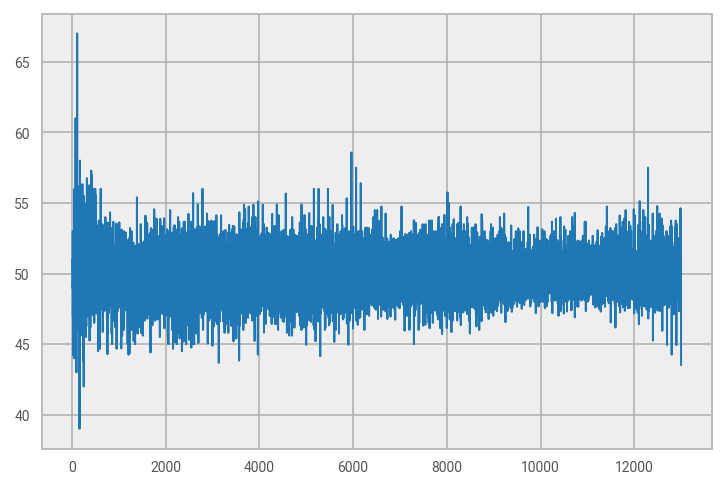

In [383]:
plt.plot(gens_rew)

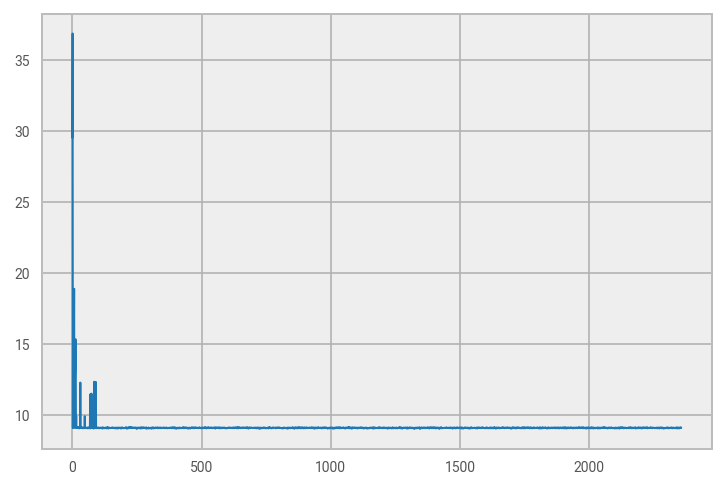

In [223]:
plt.plot(pop_rews[people[0]])

In [273]:
import pickle

In [399]:
population = pickle.load(open('population.pkl','rb'))
gens_rew = pickle.load(open('gens_rew.pkl','rb'))

In [400]:
max(population.items(), key=lambda x: x[1].reward)

('Adrian', <__main__.Entity at 0x7f5519c55748>)

In [401]:
np.mean([j.reward for i,j in population.items()])

49.29

In [294]:
[j.reward for i,j in population.items()]

[-40.9009009009009,
 -35.627272727272725,
 -0.8121827411167502,
 -34.65573770491803,
 -34.085470085470085,
 -30.12295081967213,
 0.0,
 -28.6953125,
 -17.651612903225804,
 -15.462025316455694,
 -16.0,
 -32.705882352941174,
 -37.79816513761468,
 -23.071428571428573,
 -40.87719298245614,
 -37.73451327433628,
 -40.87719298245614,
 2.153110047846887,
 -36.16949152542373,
 -8.33519553072626,
 -32.705882352941174,
 -1.813471502590673,
 0.24875621890546995,
 -35.44915254237288,
 -25.712,
 -18.39855072463768,
 -0.7614213197969519,
 -29.77777777777778,
 -15.058823529411768,
 -21.316129032258065,
 -7.142857142857146,
 -22.314285714285713,
 -40.95238095238095,
 -37.63333333333333,
 -37.75,
 -38.52252252252252,
 -37.719298245614034,
 -2.0833333333333357,
 -4.37433155080214,
 1.690821256038646,
 -32.0,
 -21.16417910447761,
 -40.91743119266055,
 -2.6315789473684177,
 0.24875621890546995,
 -36.18803418803419,
 -3.475935828877006,
 -40.970873786407765,
 -26.062992125984252,
 -25.25,
 0.738916256157637,

In [402]:
[j.reward for i,j in population.items()]

[50.0,
 50.0,
 48.0,
 50.0,
 77.0,
 45.0,
 46.0,
 46.0,
 55.0,
 51.0,
 51.0,
 45.0,
 56.0,
 47.0,
 53.0,
 49.0,
 54.0,
 47.0,
 54.0,
 53.0,
 53.0,
 56.0,
 58.0,
 50.0,
 52.0,
 41.0,
 51.0,
 43.0,
 44.0,
 52.0,
 58.0,
 55.0,
 56.0,
 42.0,
 56.0,
 50.0,
 50.0,
 47.0,
 53.0,
 53.0,
 60.0,
 42.0,
 52.0,
 42.0,
 35.0,
 47.0,
 49.0,
 48.0,
 46.0,
 53.0,
 53.0,
 57.0,
 59.0,
 23.0,
 18.0,
 78.0,
 52.0,
 50.0,
 55.0,
 52.0,
 52.0,
 40.0,
 47.0,
 56.0,
 48.0,
 32.0,
 54.0,
 49.0,
 43.0,
 55.0,
 51.0,
 45.0,
 38.0,
 50.0,
 49.0,
 48.0,
 46.0,
 44.0,
 52.0,
 54.0,
 55.0,
 50.0,
 50.0,
 54.0,
 49.0,
 47.0,
 49.0,
 46.0,
 52.0,
 50.0,
 56.0,
 56.0,
 57.0,
 39.0,
 48.0,
 41.0,
 52.0,
 44.0,
 14.0,
 49.0]

In [403]:
population['Adrian'].reward

78.0

In [410]:
entity = population['Elijah']
temp = Entity()
temp.open_for_sell = True
cntr = 0
while entity.alive:
    print('**************************',cntr,'******************************')
    entity.action(partner=temp)
    print({i:j for i,j in vars(entity).items() if (i != 'brain') & (i != 'memory') & (i != 'decisions_logits')
           & (i != 'open_for_sell_logits') & (i != 'open_for_purchase_logits') & (i != 'optimizer')
          & (i != 'all_rews')})
    cntr += 1

************************** 0 ******************************
{'food': 99, 'money': 100.0, 'life': 99.0, 'hunger': 0, 'gamma': 0.9, 'reward': 4.337899543378995, 'baseline': 50, 'life_decisions': ['eat'], 'mem_cntr': 1, 'alive': True, 'sell_rate': 1, 'purchase_rate': 1, 'open_for_sell': True, 'open_for_purchase': False}
************************** 1 ******************************
{'food': 98, 'money': 100.0, 'life': 98.0, 'hunger': 0, 'gamma': 0.9, 'reward': 4.337899543378995, 'baseline': 50, 'life_decisions': ['eat', 'eat'], 'mem_cntr': 2, 'alive': True, 'sell_rate': 1, 'purchase_rate': 1, 'open_for_sell': True, 'open_for_purchase': False}
************************** 2 ******************************
{'food': 97, 'money': 100.0, 'life': 97.0, 'hunger': 0, 'gamma': 0.9, 'reward': 4.337899543378995, 'baseline': 50, 'life_decisions': ['eat', 'eat', 'eat'], 'mem_cntr': 3, 'alive': True, 'sell_rate': 1, 'purchase_rate': 1, 'open_for_sell': True, 'open_for_purchase': False}
**********************

In [409]:
entity.learn()

In [321]:
entity.life_decisions.count('sell')

39

In [322]:
entity.life_decisions.count('eat')

61

In [306]:
vars(entity)

{'alive': False,
 'all_rews': [-40.08035714285714,
  2.153110047846887,
  -2.356020942408378,
  -0.2512562814070378,
  -0.2512562814070378,
  -0.5050505050505052,
  0.0,
  -0.5050505050505052,
  -0.5050505050505052,
  0.0,
  -0.5050505050505052,
  0.24875621890546995,
  -1.5463917525773212,
  -1.813471502590673,
  -1.5463917525773212,
  -0.2512562814070378,
  0.0,
  -0.2512562814070378,
  1.4563106796116472,
  -1.2820512820512846,
  1.690821256038646,
  1.9230769230769198,
  1.2195121951219505,
  -0.7614213197969519,
  0.24875621890546995,
  0.0,
  0.738916256157637,
  0.738916256157637,
  -1.813471502590673,
  0.24875621890546995,
  1.2195121951219505,
  -1.2820512820512846,
  -1.2820512820512846,
  0.0,
  -0.2512562814070378,
  -0.7614213197969519,
  0.9803921568627416,
  0.24875621890546995,
  0.0,
  -0.7614213197969519,
  0.738916256157637,
  -1.0204081632653086,
  -0.7614213197969519,
  -1.0204081632653086,
  0.738916256157637,
  1.690821256038646,
  -0.2512562814070378,
  1.45631

*************************************** Michael ***********************************
47.0


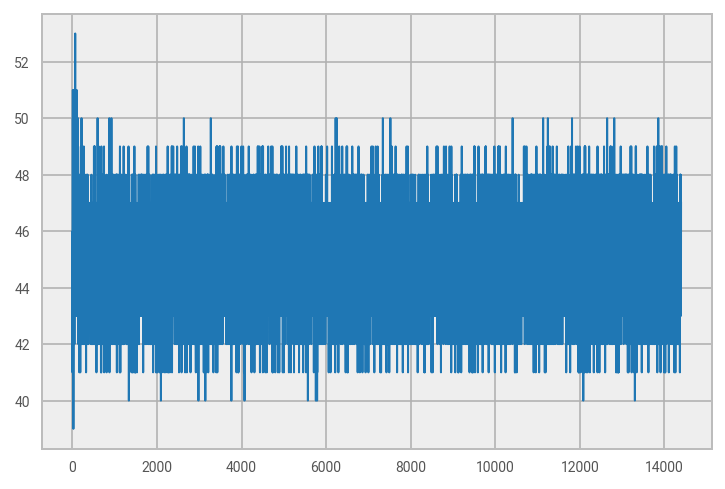

*************************************** Jackson ***********************************
54.0


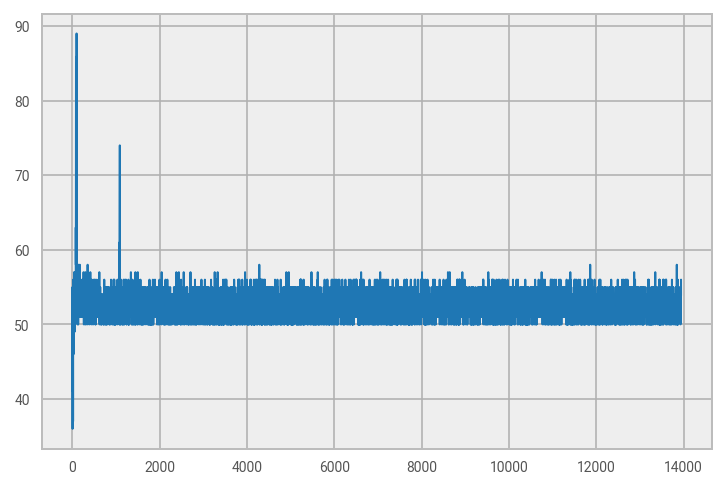

*************************************** Carter ***********************************
52.0


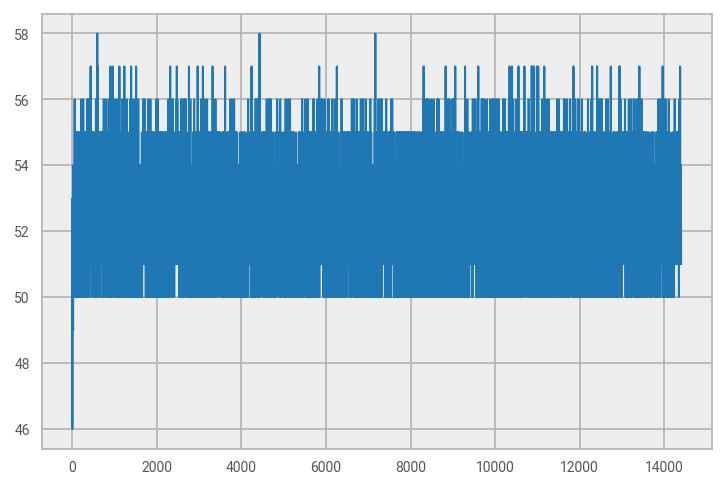

*************************************** Ezra ***********************************
46.0


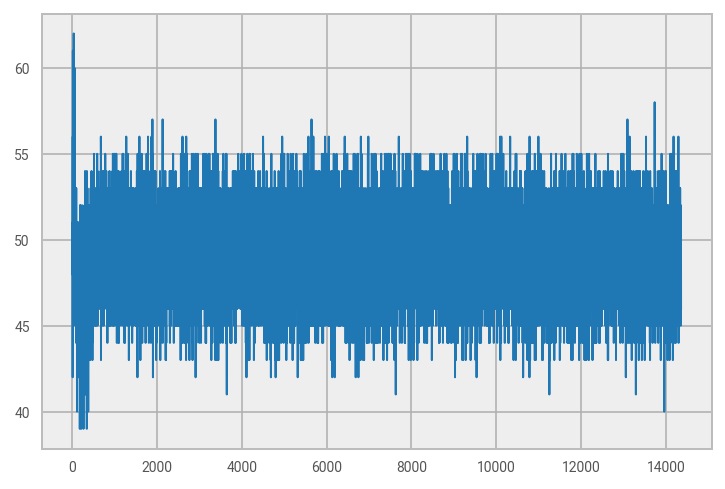

*************************************** Roman ***********************************
38.0


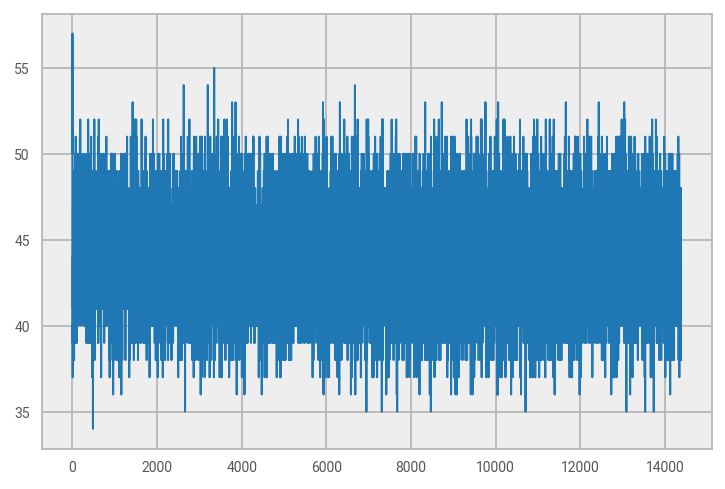

*************************************** Easton ***********************************
50.0


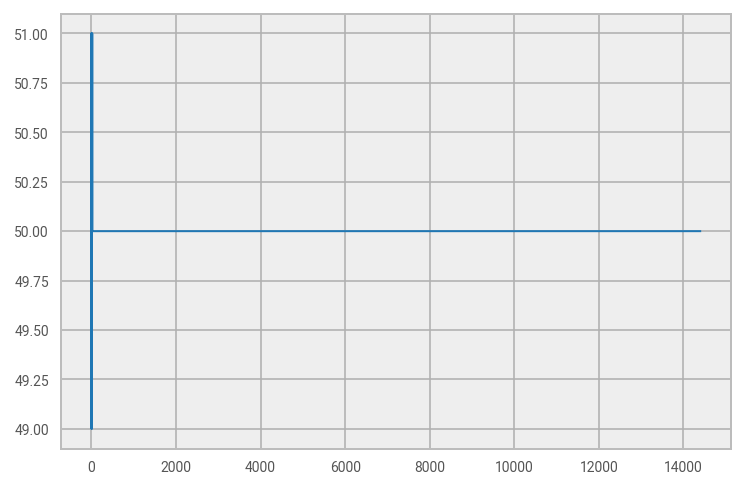

*************************************** Jace ***********************************
57.0


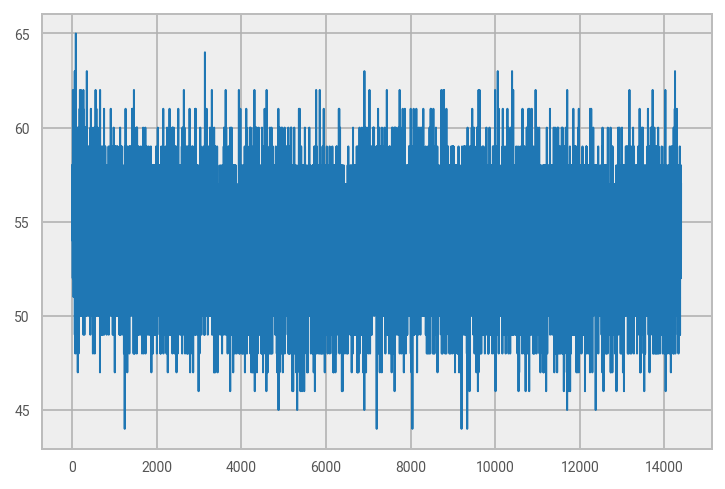

*************************************** Andrew ***********************************
47.0


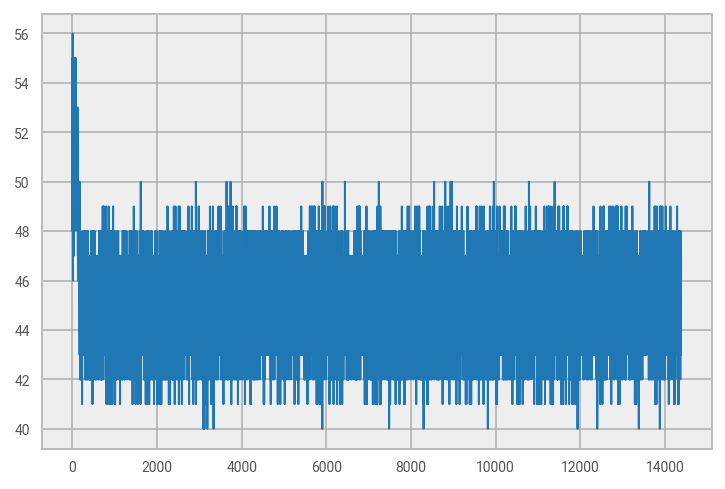

*************************************** Theodore ***********************************
50.0


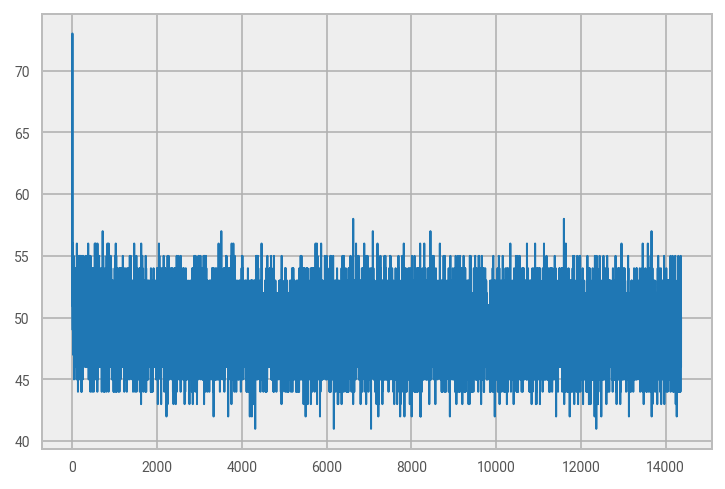

*************************************** Henry ***********************************
45.0


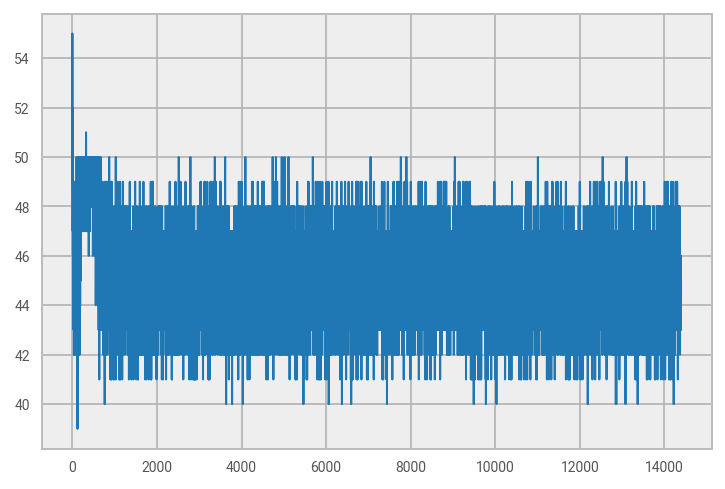

*************************************** Wesley ***********************************
14.0


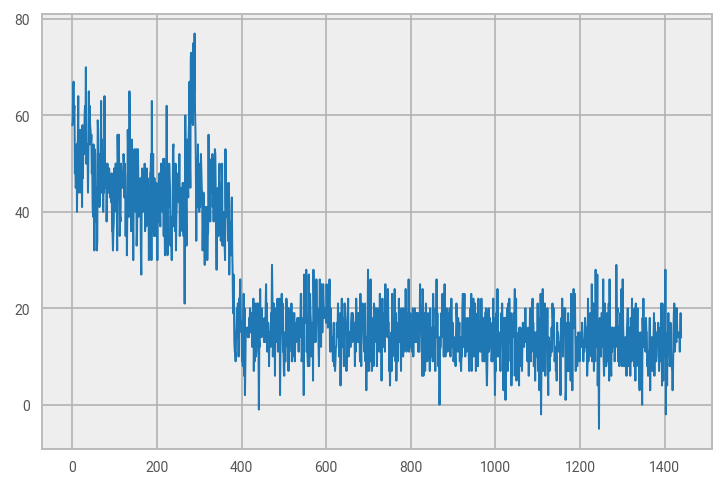

*************************************** Logan ***********************************
49.0


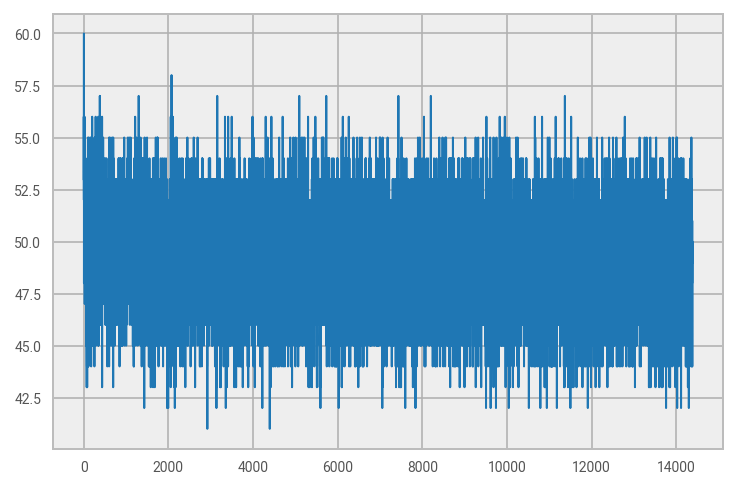

*************************************** Aiden ***********************************
53.0


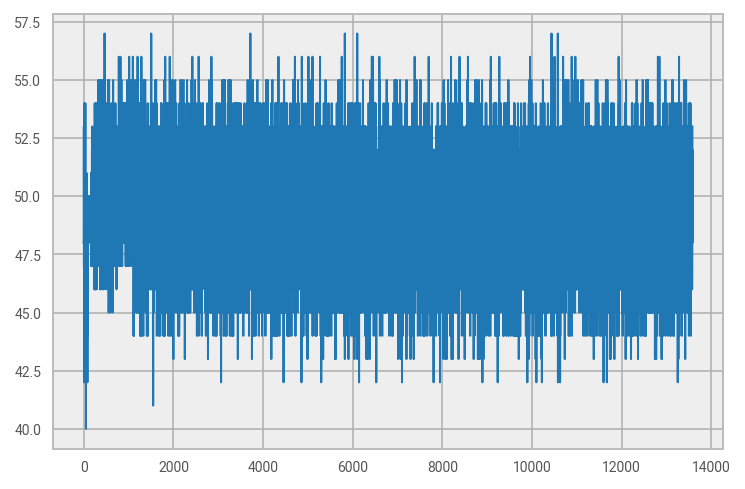

*************************************** David ***********************************
51.0


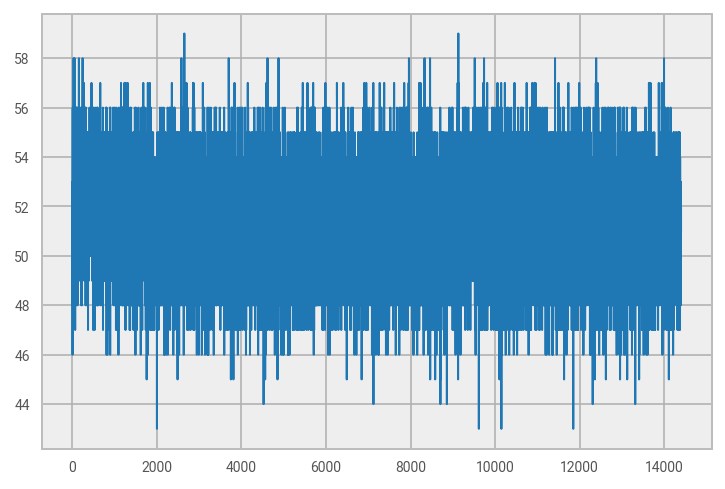

*************************************** Maverick ***********************************
50.0


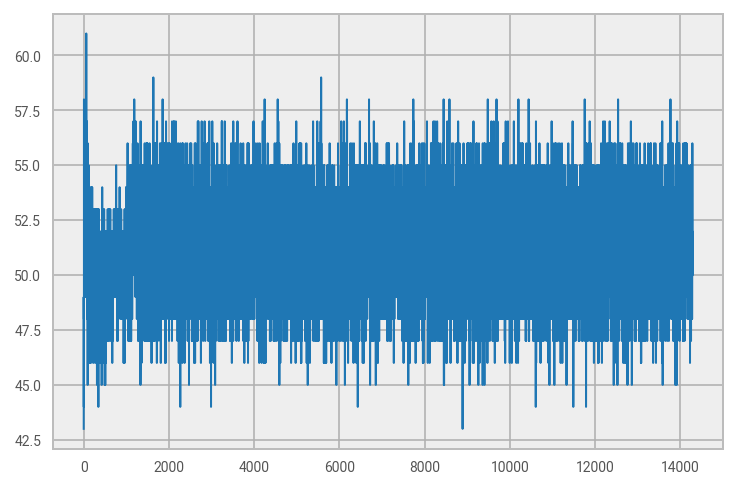

*************************************** Matthew ***********************************
58.0


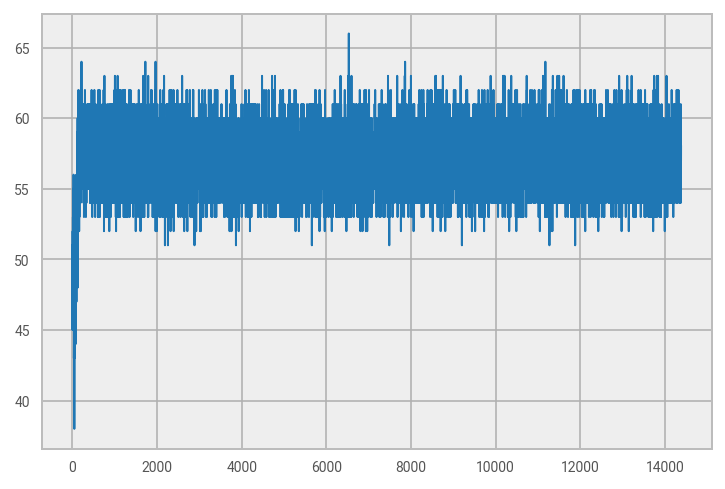

*************************************** Liam ***********************************
50.0


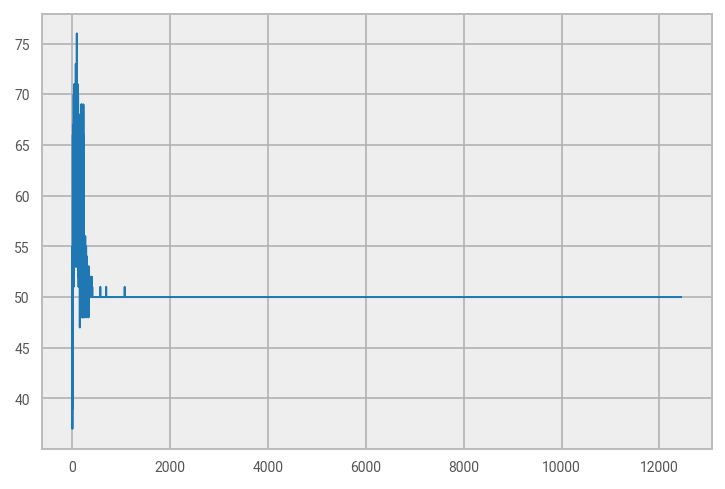

*************************************** Santiago ***********************************
43.0


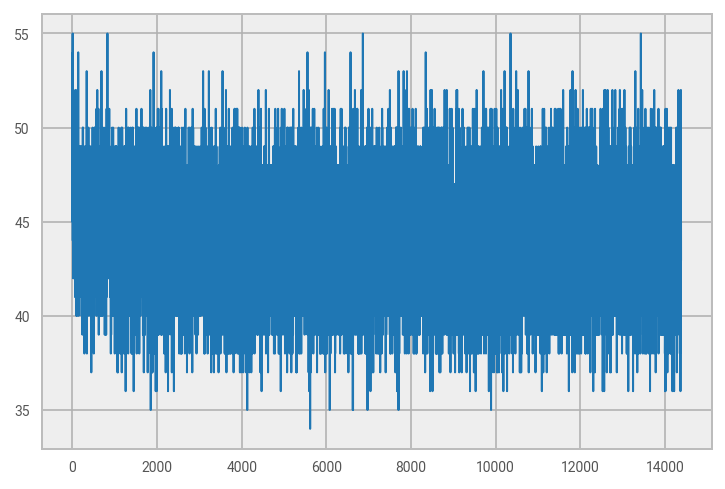

*************************************** Christopher ***********************************
42.0


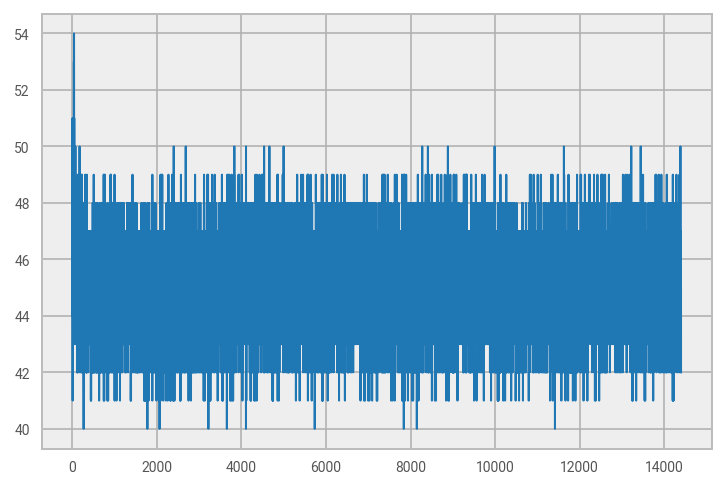

*************************************** Angel ***********************************
45.0


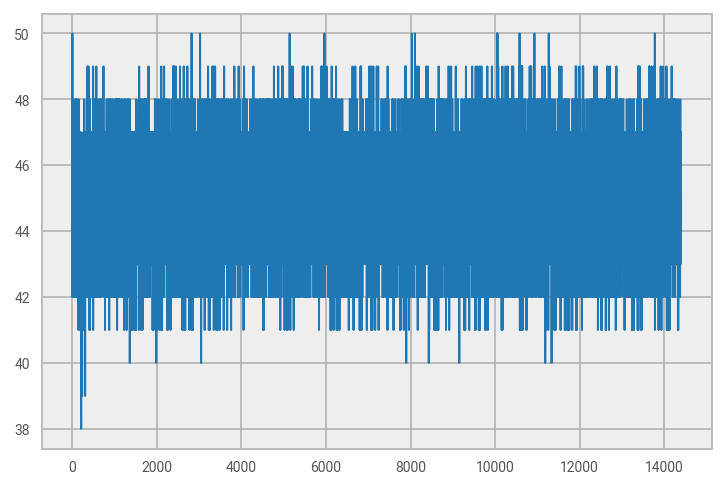

*************************************** Grayson ***********************************
56.0


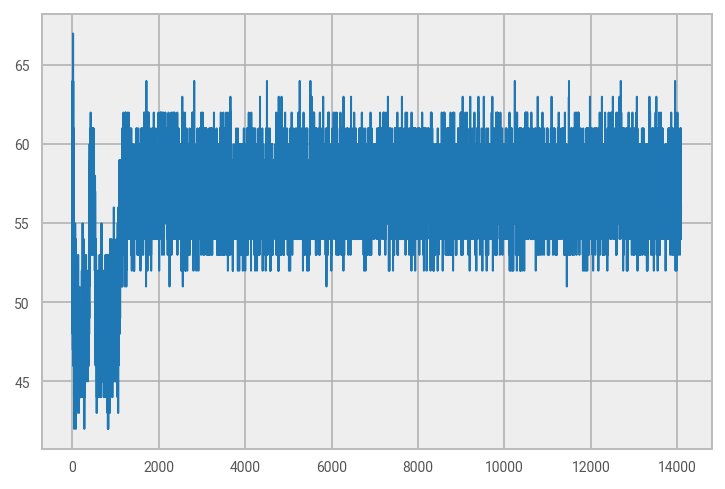

*************************************** Landon ***********************************
47.0


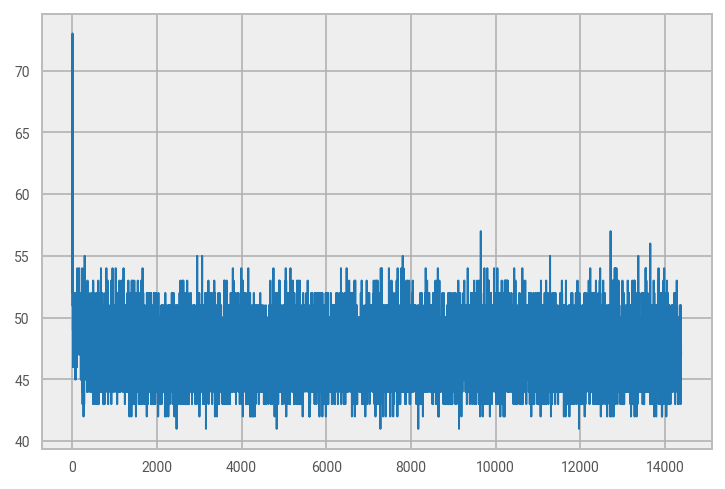

*************************************** Cameron ***********************************
54.0


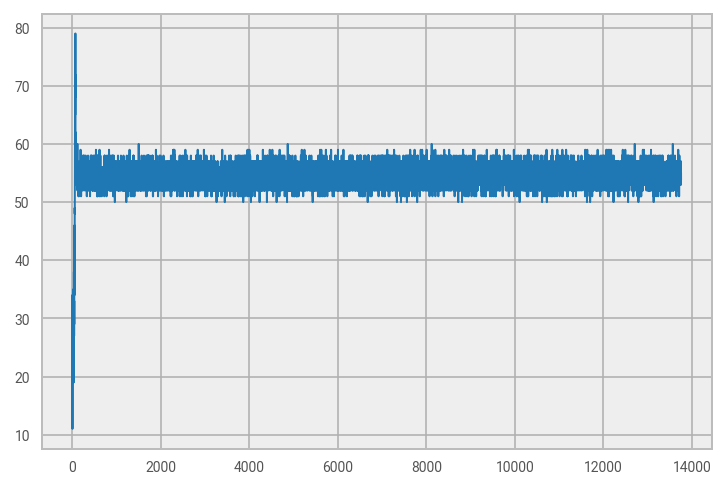

*************************************** Jaxson ***********************************
54.0


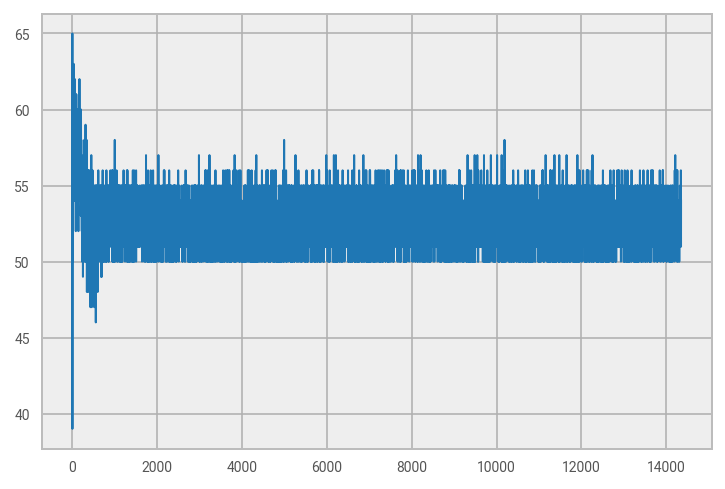

*************************************** Josiah ***********************************
35.0


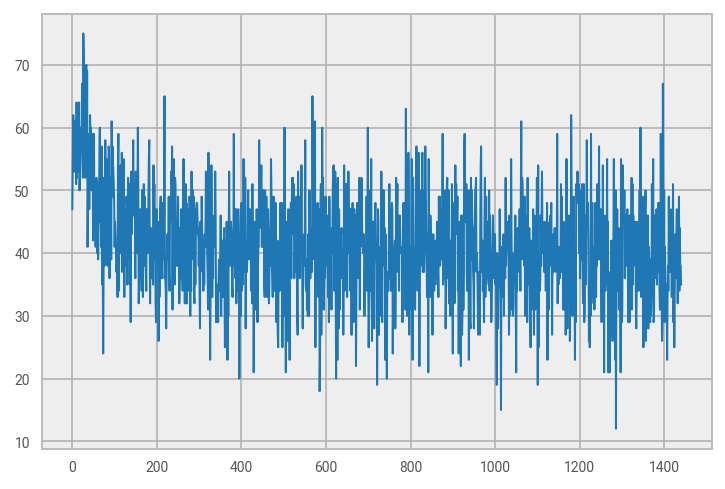

*************************************** Kayden ***********************************
52.0


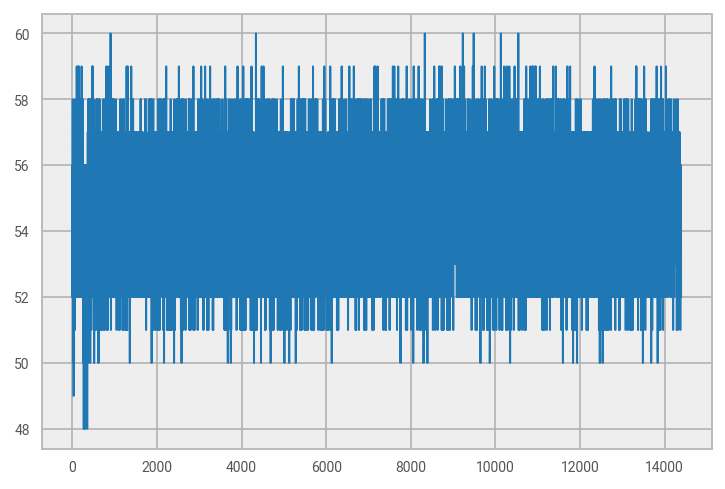

*************************************** Ian ***********************************
55.0


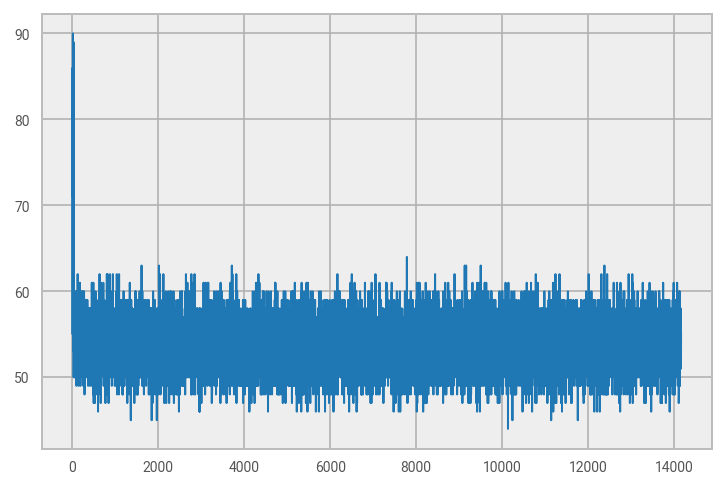

*************************************** Xavier ***********************************
56.0


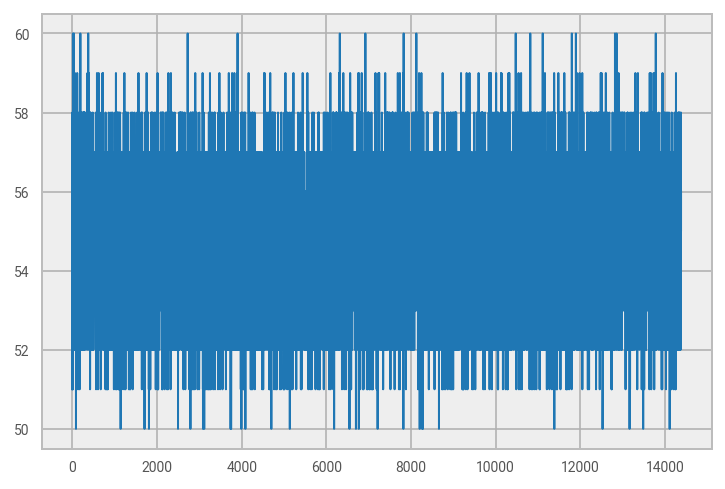

*************************************** Wyatt ***********************************
44.0


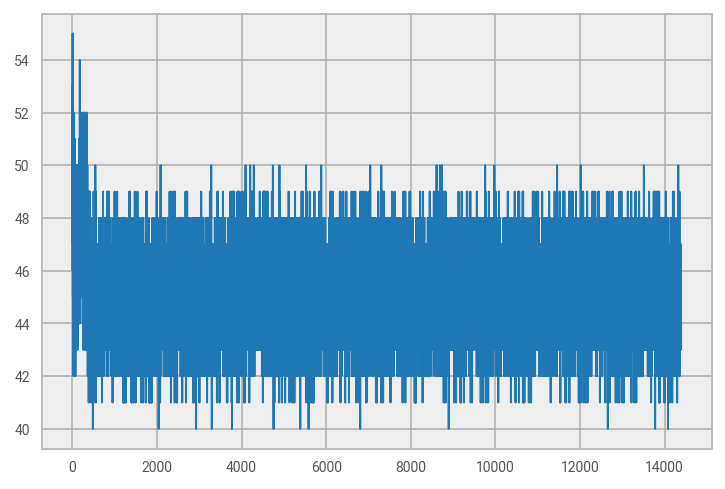

*************************************** Isaiah ***********************************
59.0


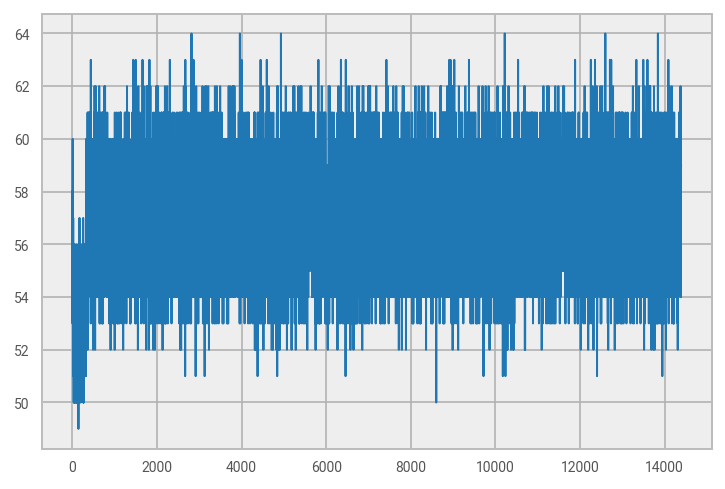

*************************************** Aaron ***********************************
52.0


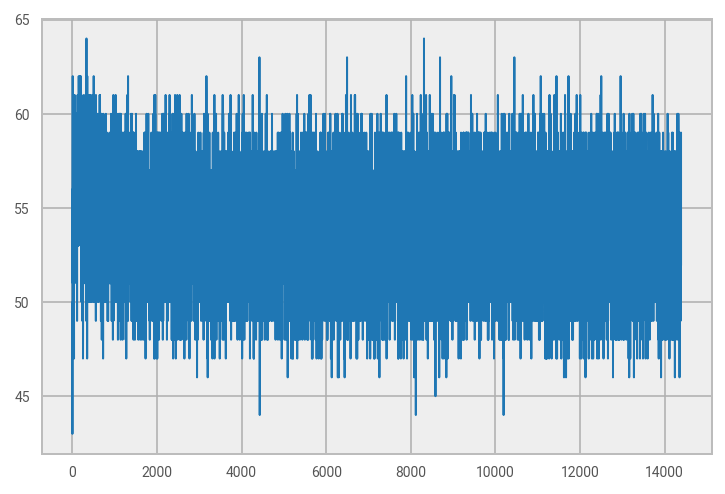

*************************************** Miles ***********************************
49.0


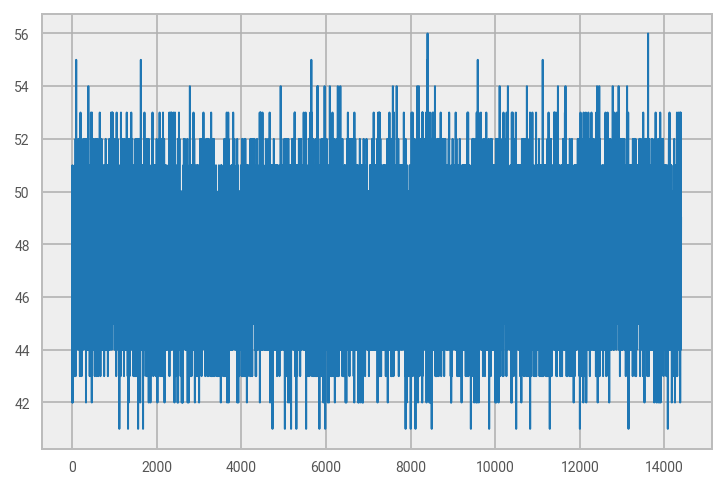

*************************************** Jameson ***********************************
46.0


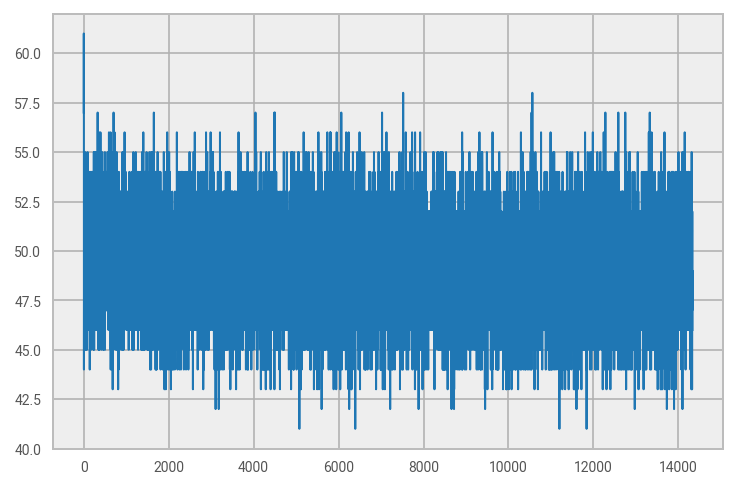

*************************************** Adam ***********************************
50.0


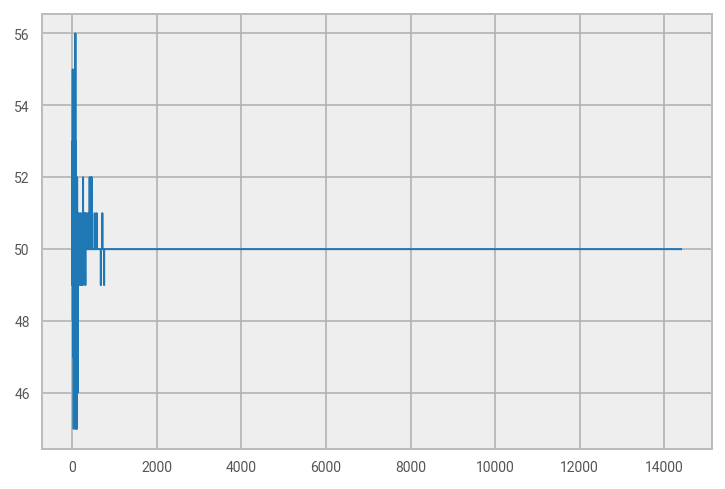

*************************************** Dominic ***********************************
49.0


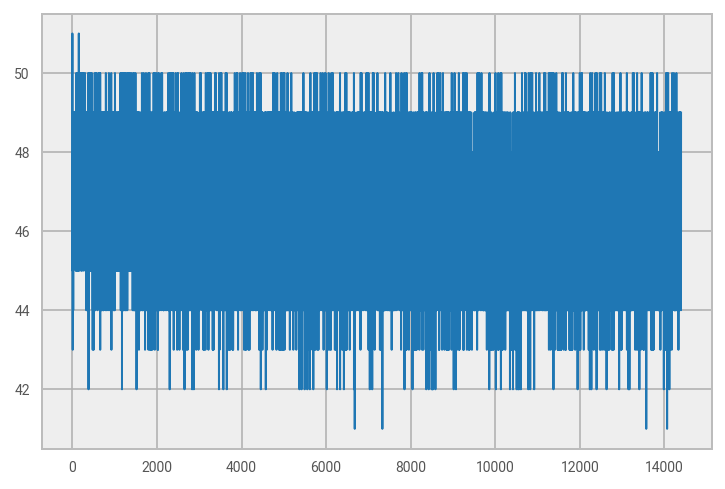

*************************************** James ***********************************
45.0


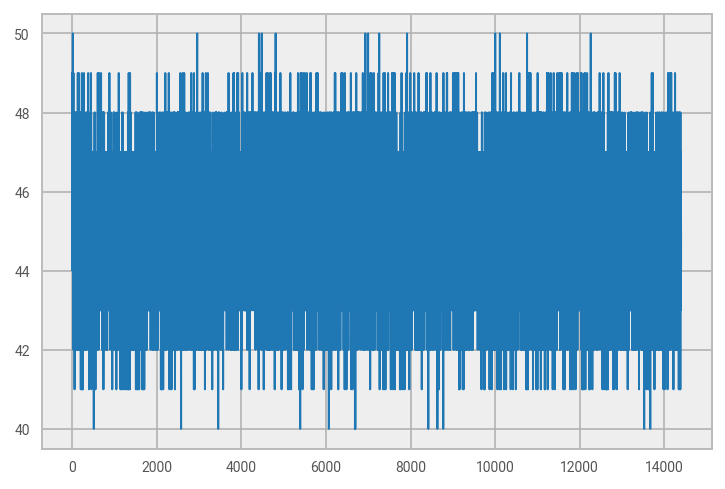

*************************************** Austin ***********************************
46.0


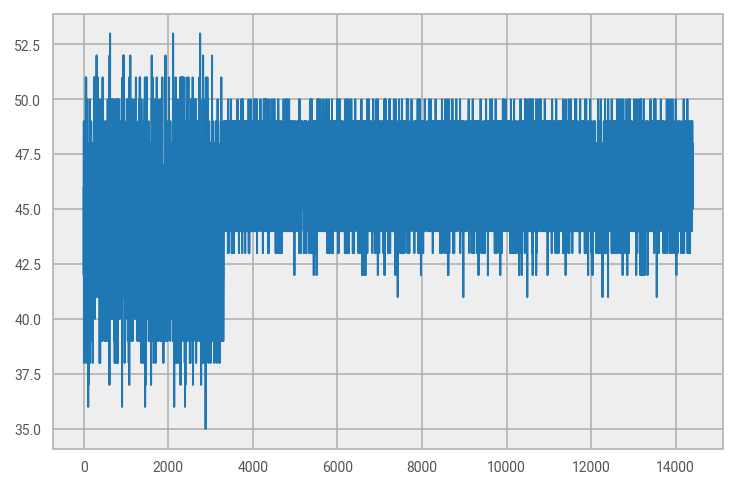

*************************************** Levi ***********************************
52.0


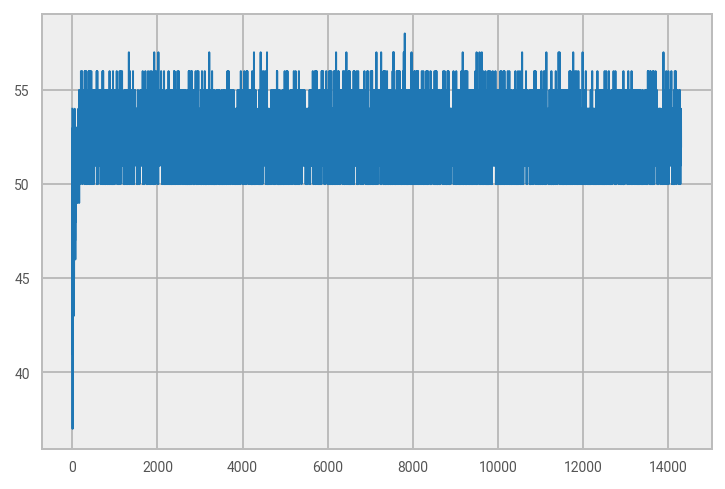

*************************************** Alexander ***********************************
51.0


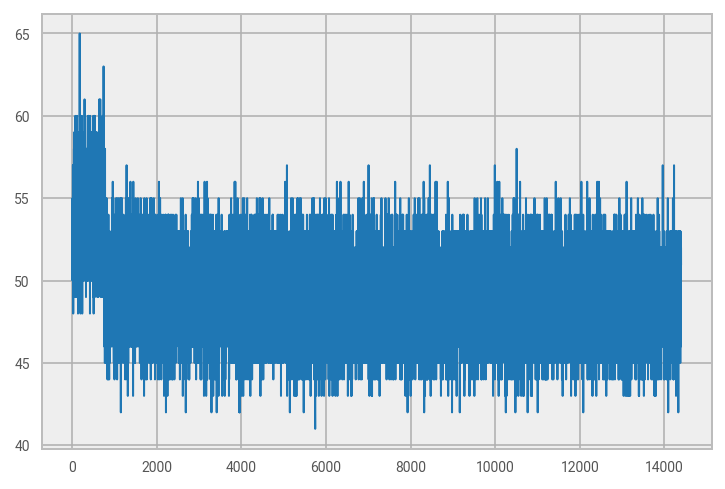

*************************************** Mason ***********************************
55.0


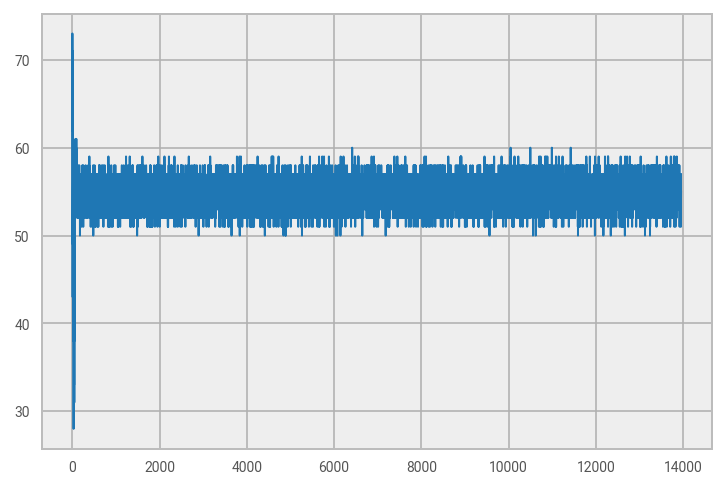

*************************************** Nathan ***********************************
18.0


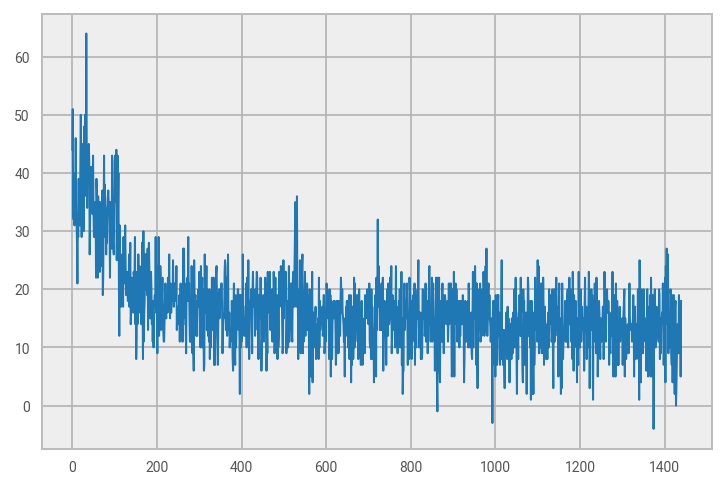

*************************************** Jaxon ***********************************
42.0


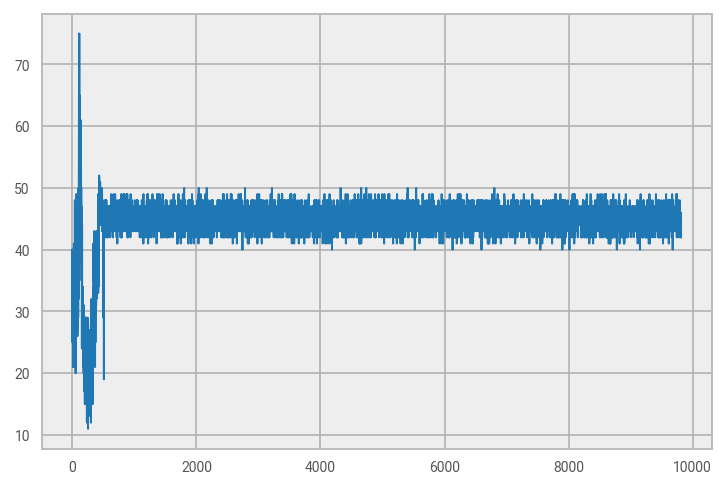

*************************************** Samuel ***********************************
56.0


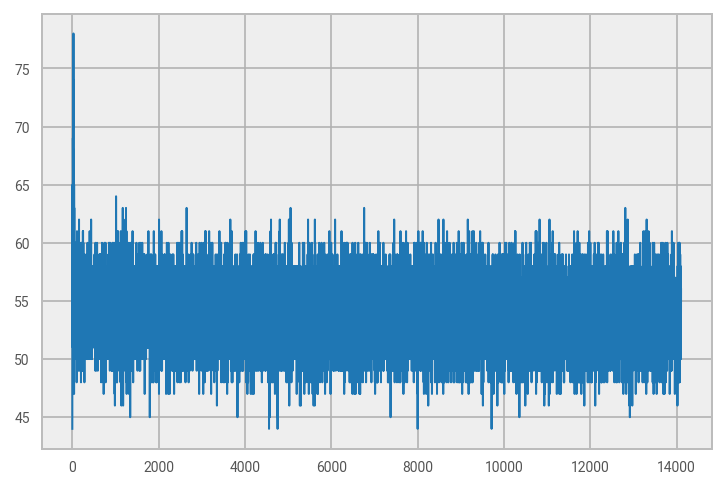

*************************************** Everett ***********************************
39.0


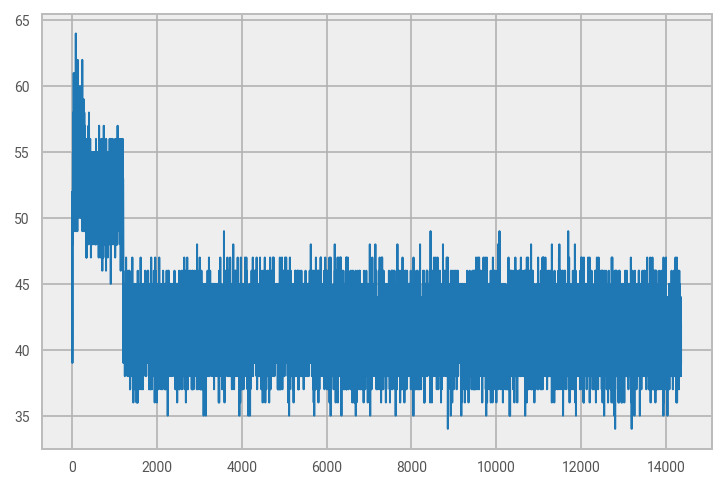

*************************************** Mateo ***********************************
41.0


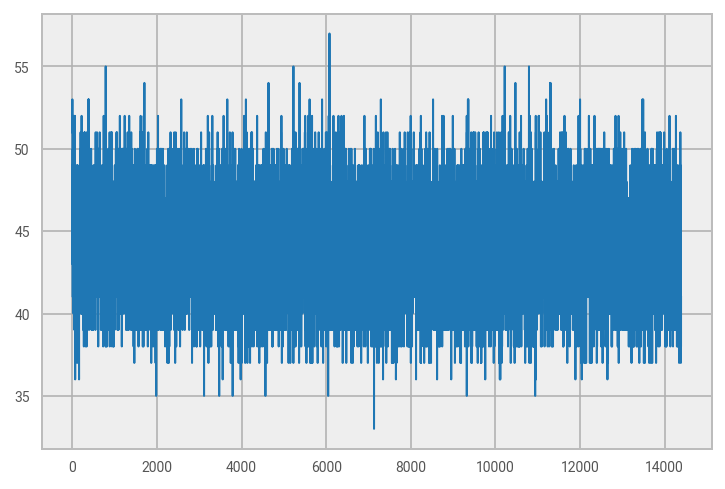

*************************************** Gabriel ***********************************
50.0


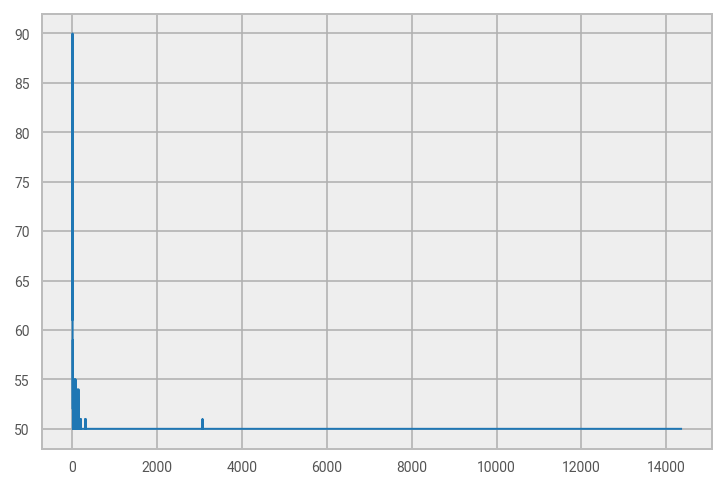

*************************************** Luca ***********************************
49.0


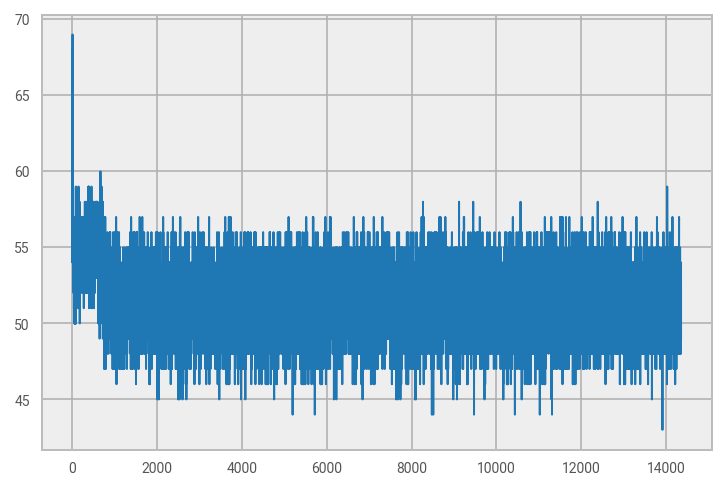

*************************************** Carson ***********************************
50.0


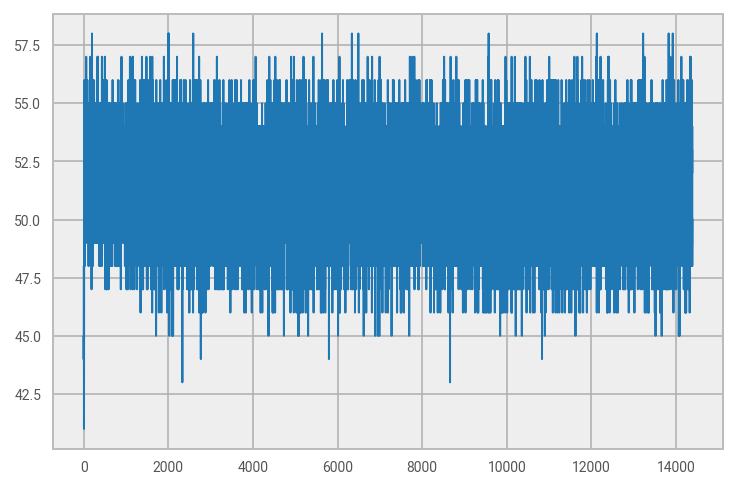

*************************************** Adrian ***********************************
1.690821256038646


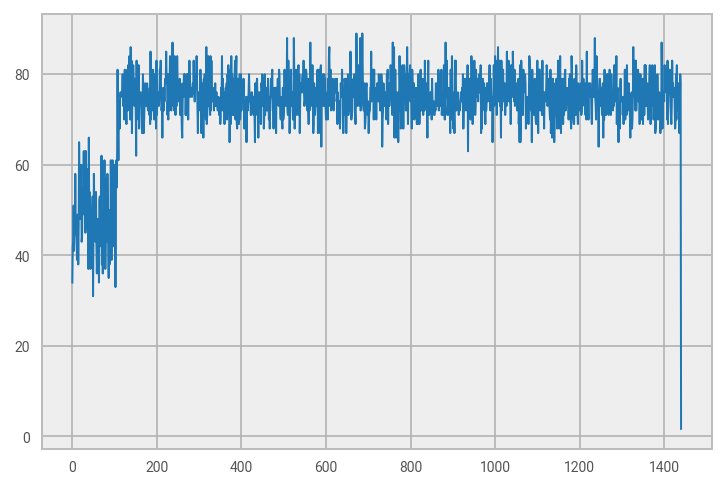

*************************************** Asher ***********************************
52.0


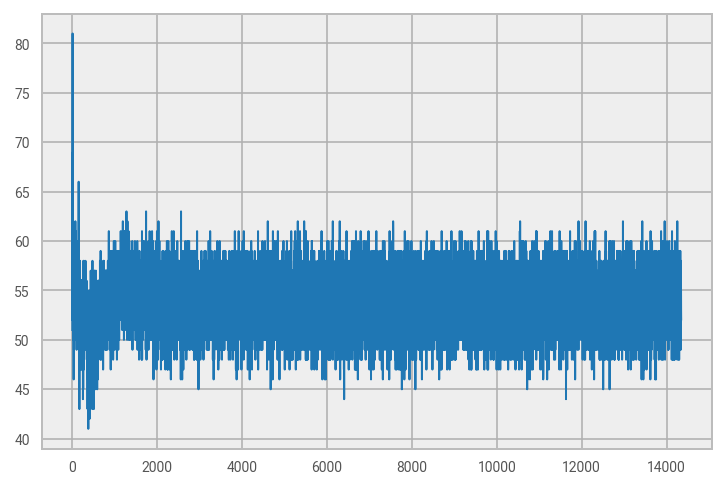

*************************************** Thomas ***********************************
49.0


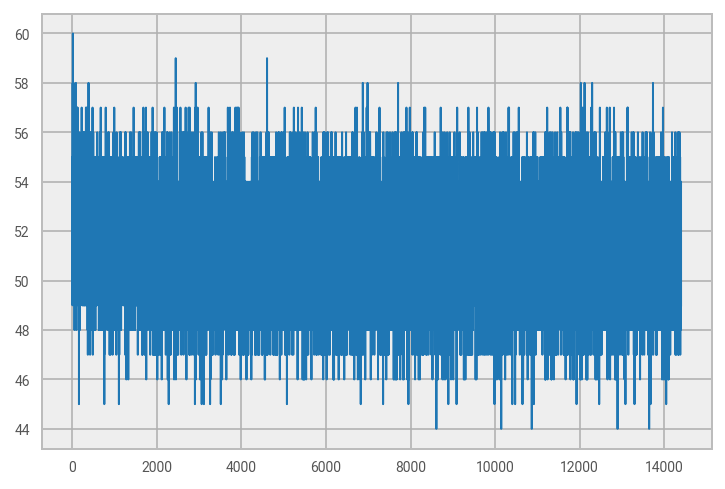

*************************************** William ***********************************
50.0


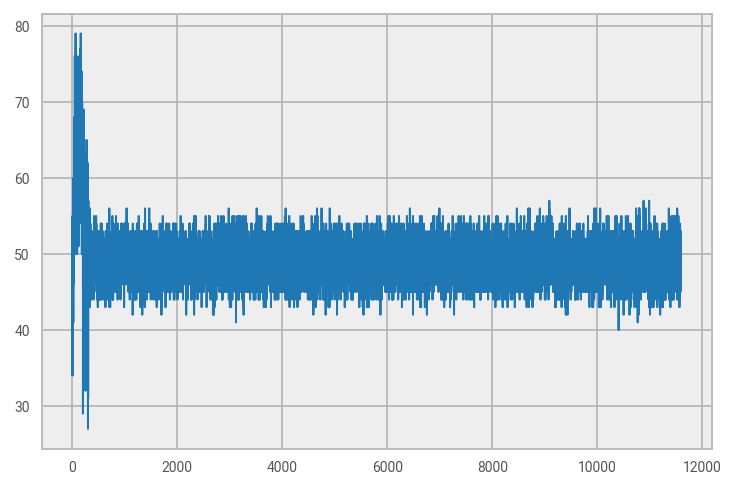

*************************************** Benjamin ***********************************
46.0


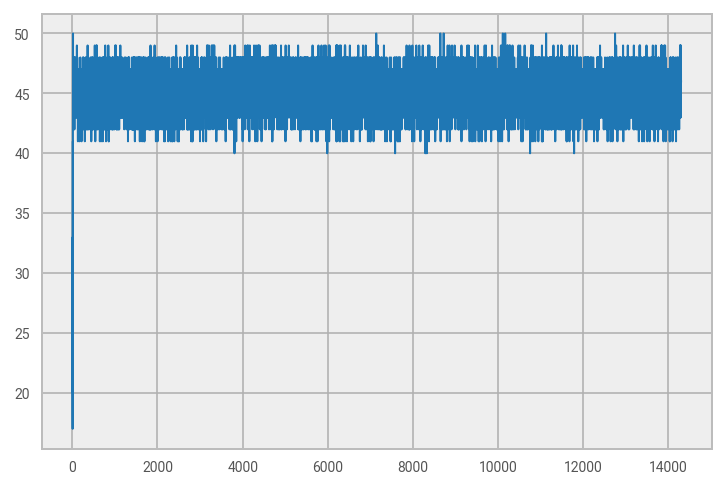

*************************************** Parker ***********************************
44.0


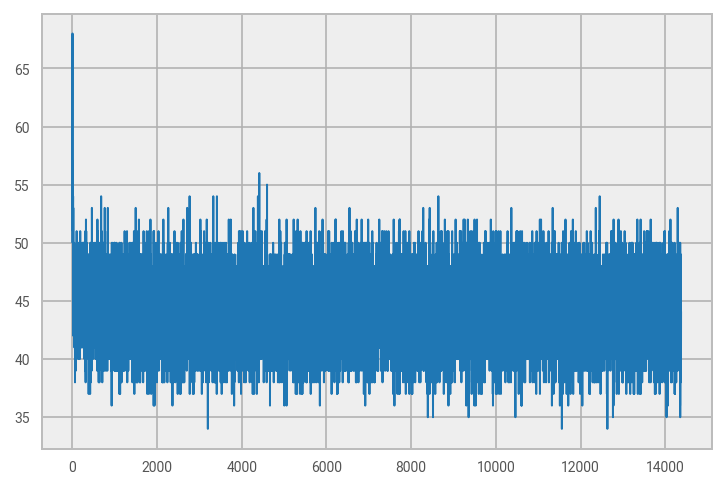

*************************************** Jose ***********************************
56.0


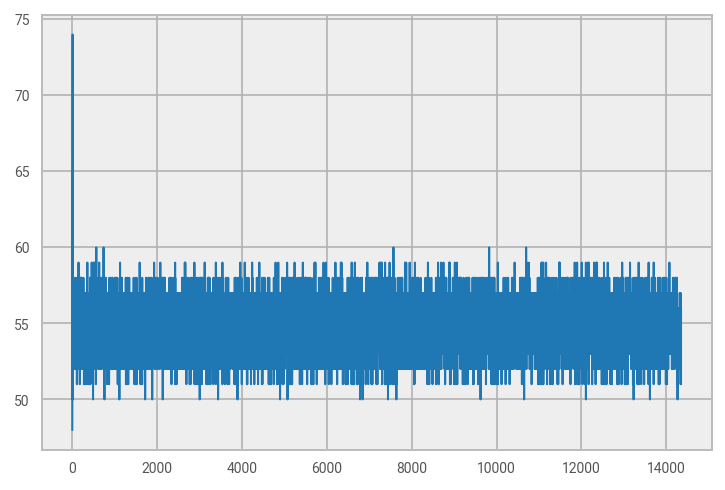

*************************************** Julian ***********************************
58.0


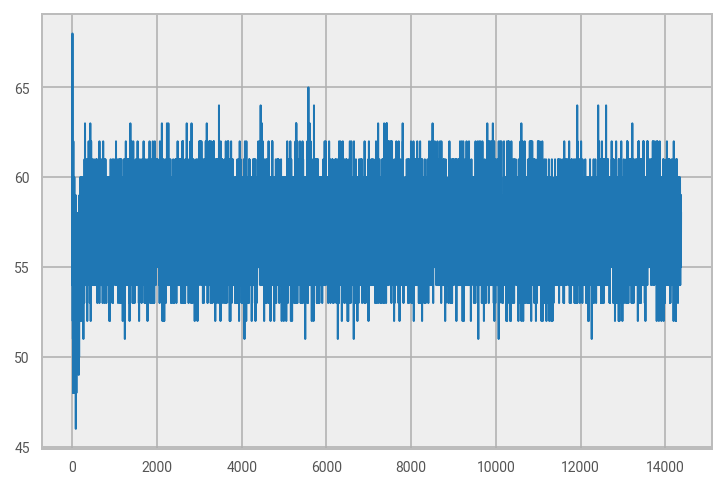

*************************************** Ryan ***********************************
23.0


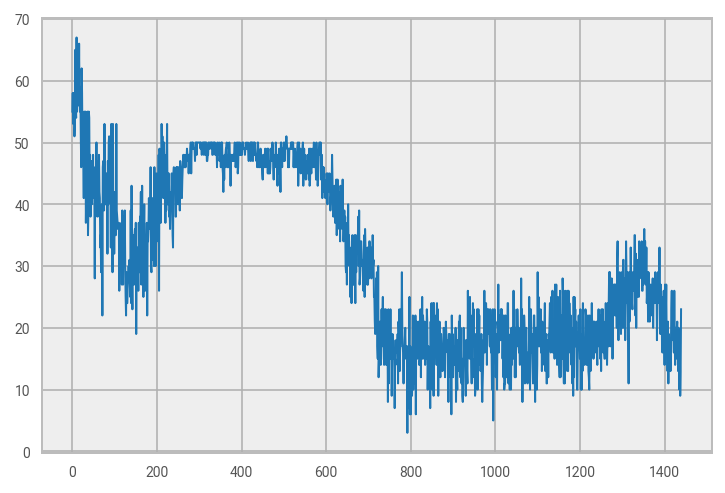

*************************************** Jack ***********************************
54.0


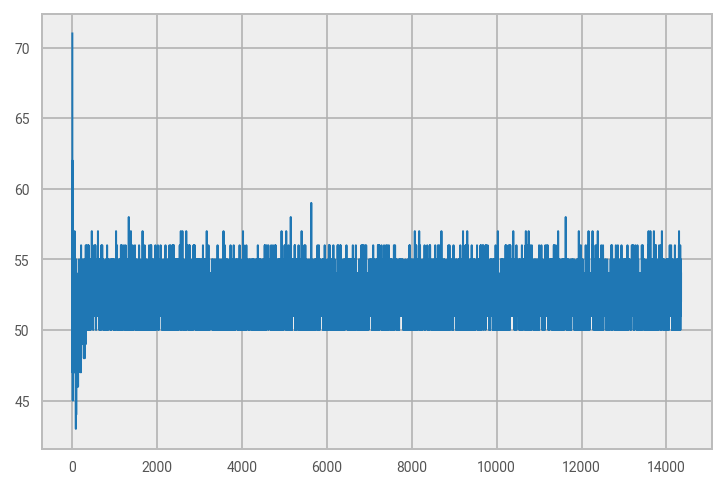

*************************************** Owen ***********************************
53.0


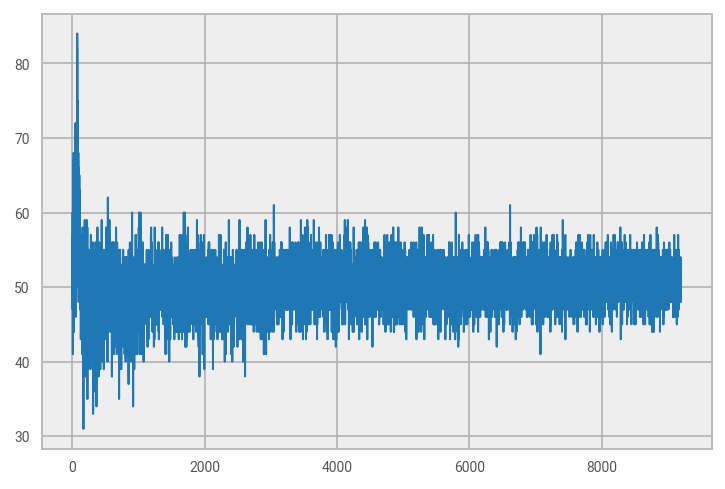

*************************************** Noah ***********************************
50.0


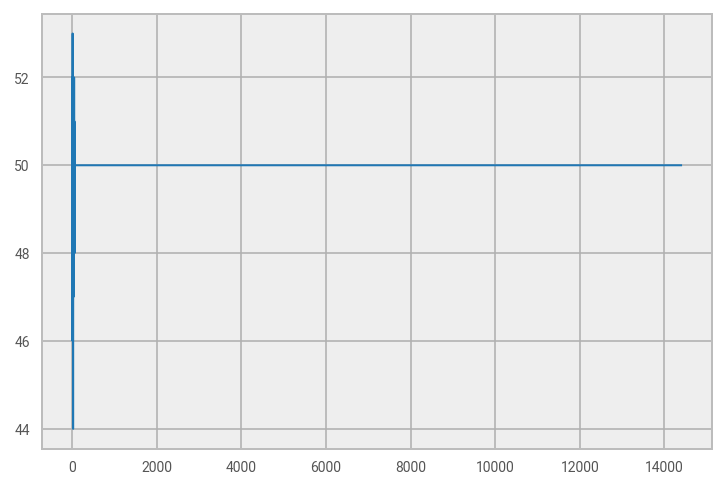

*************************************** Lincoln ***********************************
60.0


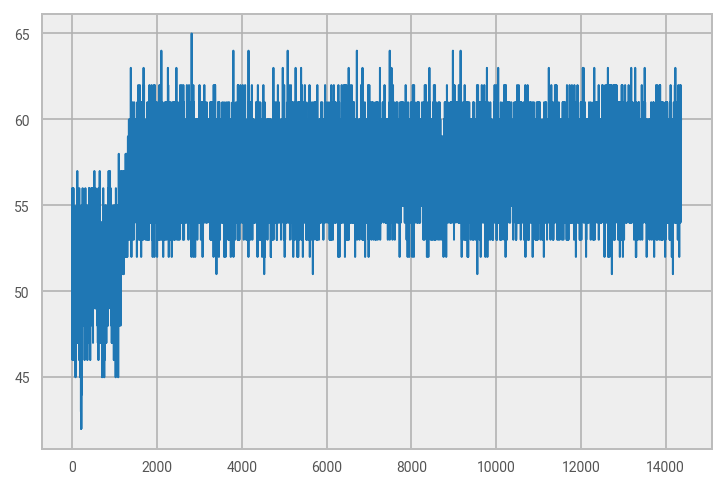

*************************************** Sebastian ***********************************
47.0


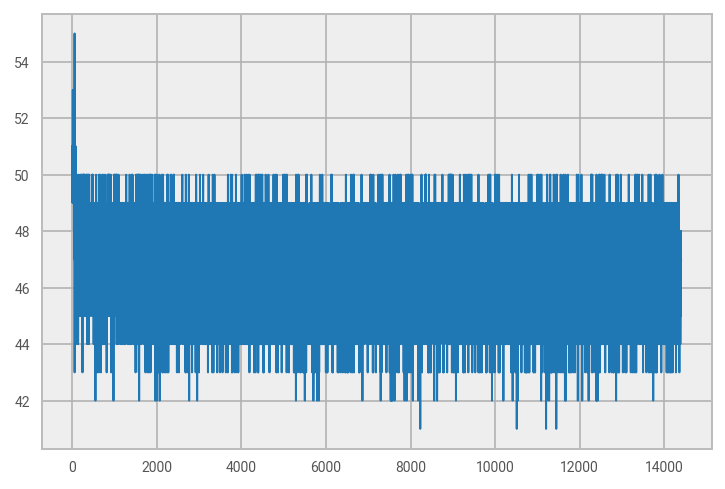

*************************************** Kai ***********************************
49.0


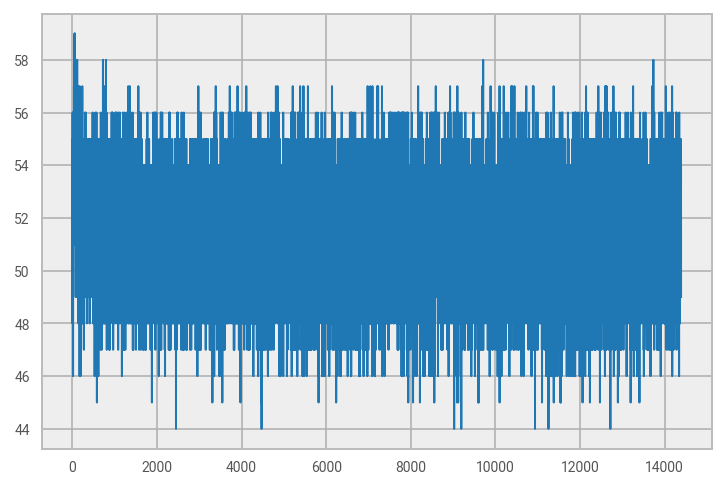

*************************************** Leonardo ***********************************
47.0


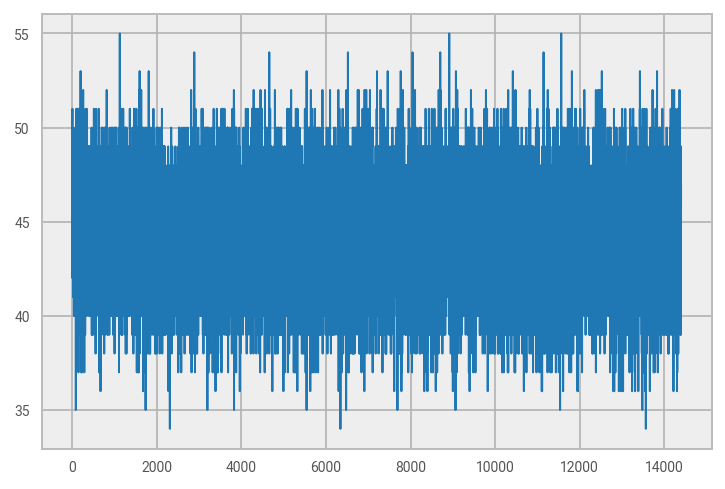

*************************************** Robert ***********************************
48.0


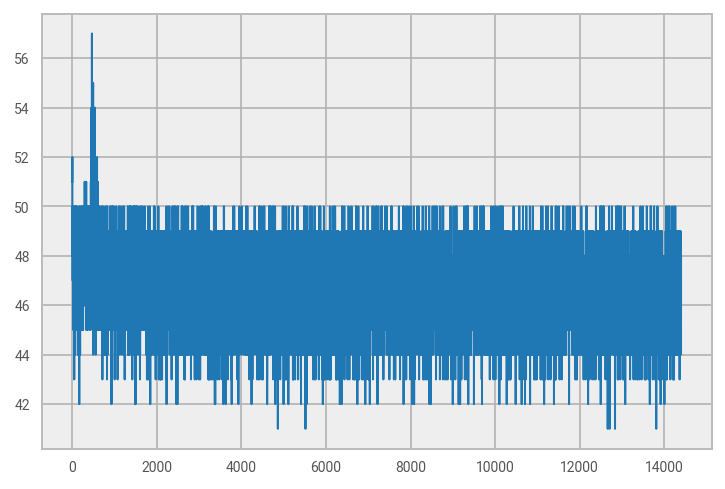

*************************************** Axel ***********************************
50.0


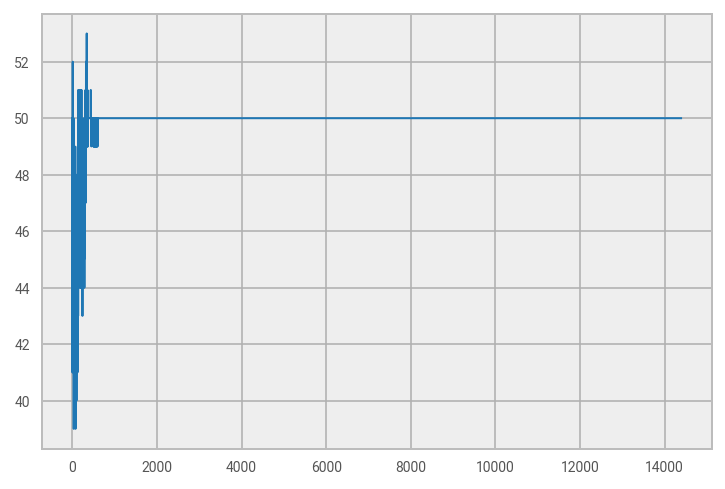

*************************************** Jonathan ***********************************
56.0


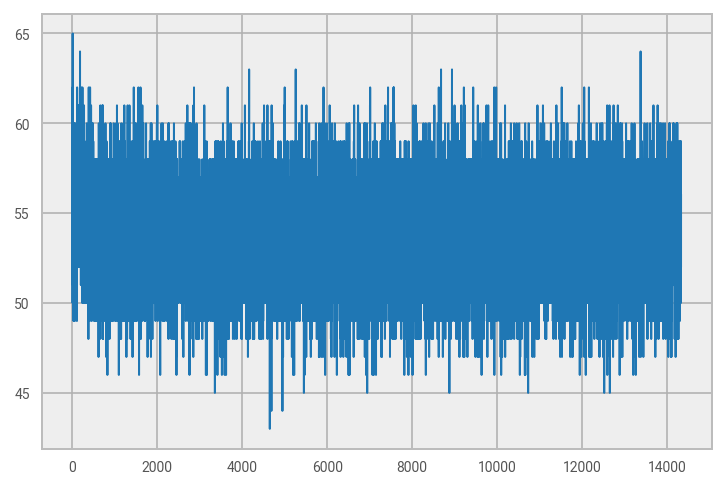

*************************************** Ethan ***********************************
51.0


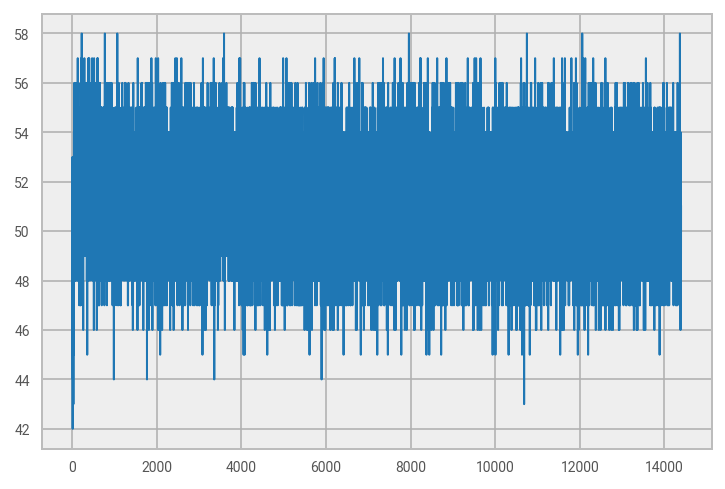

*************************************** Nolan ***********************************
48.0


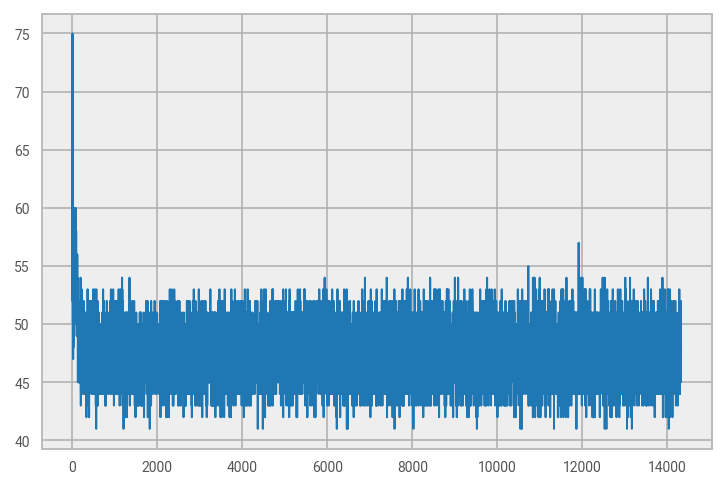

*************************************** Ezekiel ***********************************
51.0


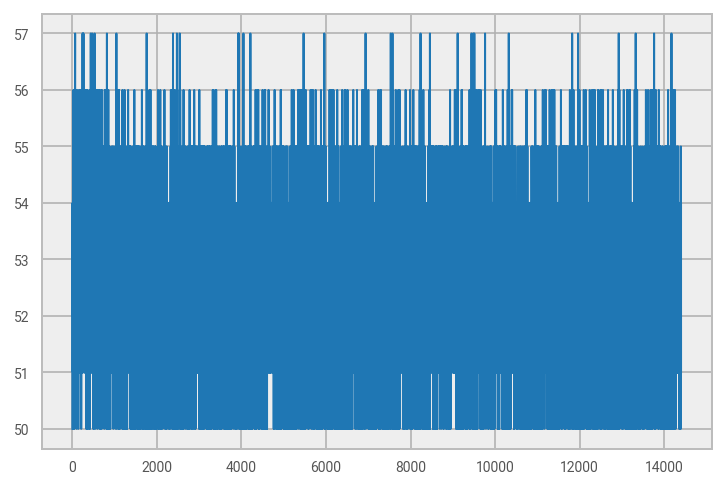

*************************************** Dylan ***********************************
53.0


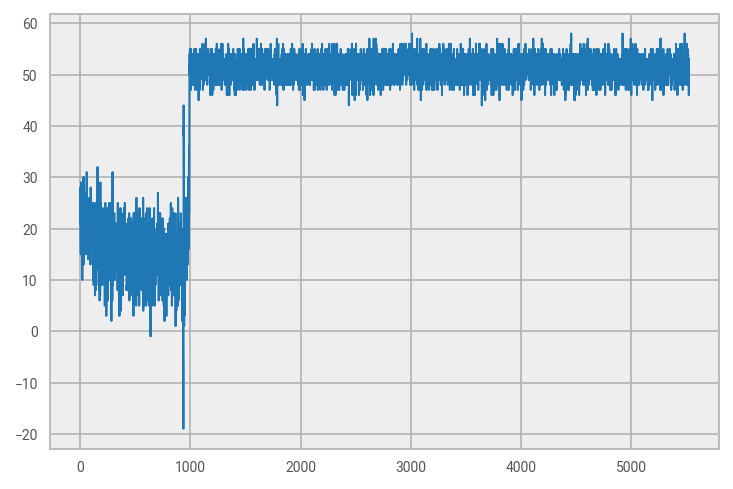

*************************************** Cooper ***********************************
54.0


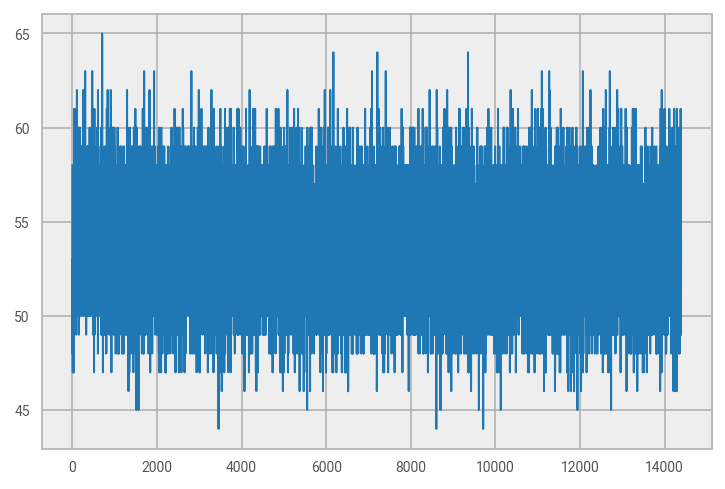

*************************************** Daniel ***********************************
53.0


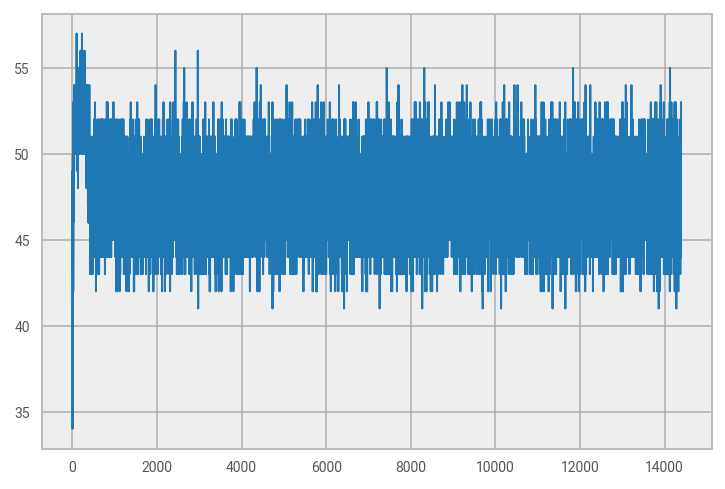

*************************************** Elias ***********************************
52.0


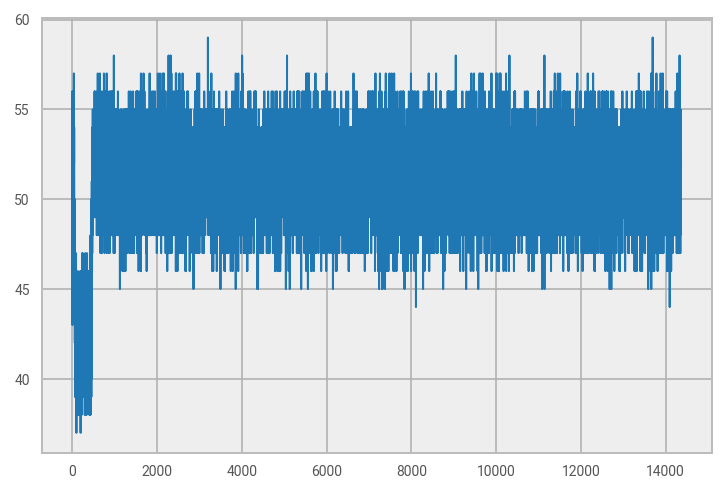

*************************************** Evan ***********************************
41.0


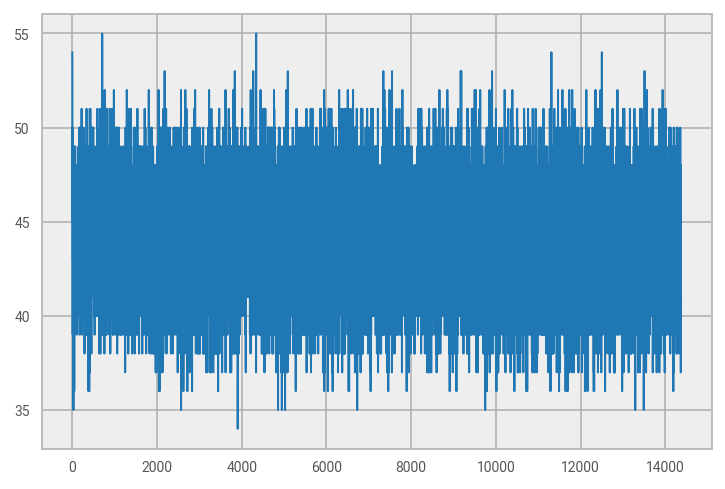

*************************************** Jacob ***********************************
56.0


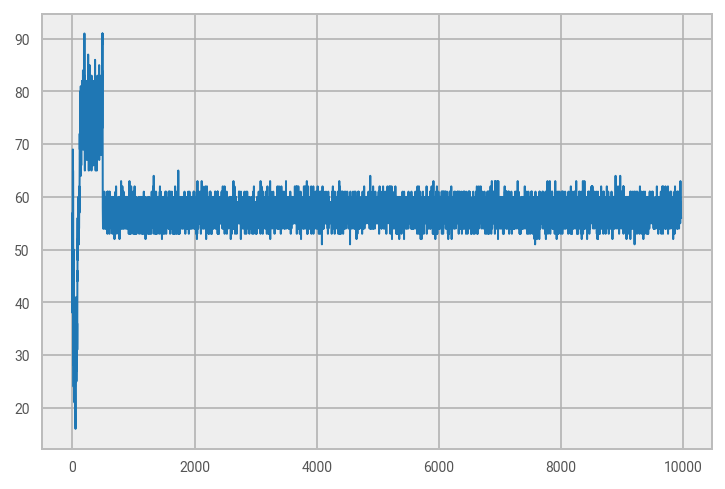

*************************************** Connor ***********************************
49.0


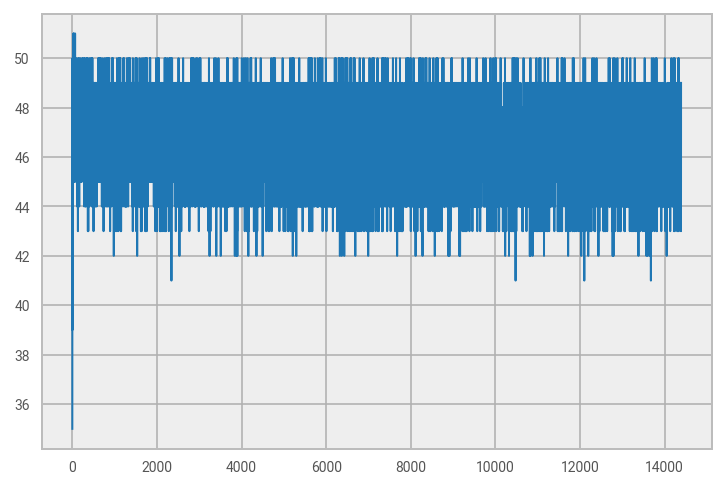

*************************************** Jordan ***********************************
52.0


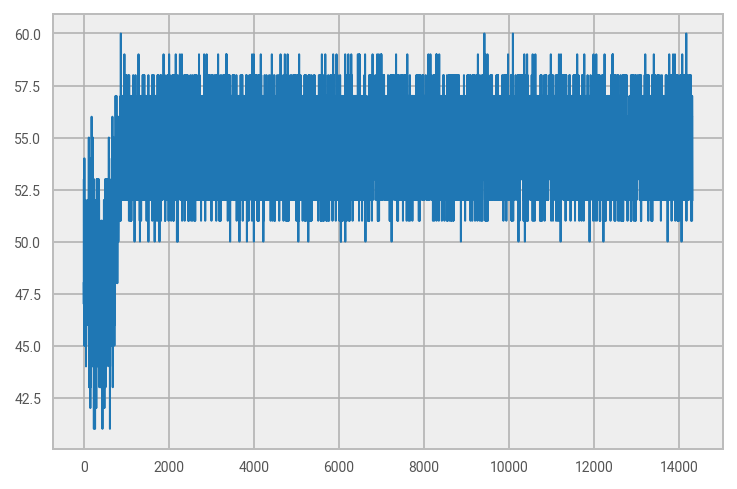

*************************************** Hunter ***********************************
32.0


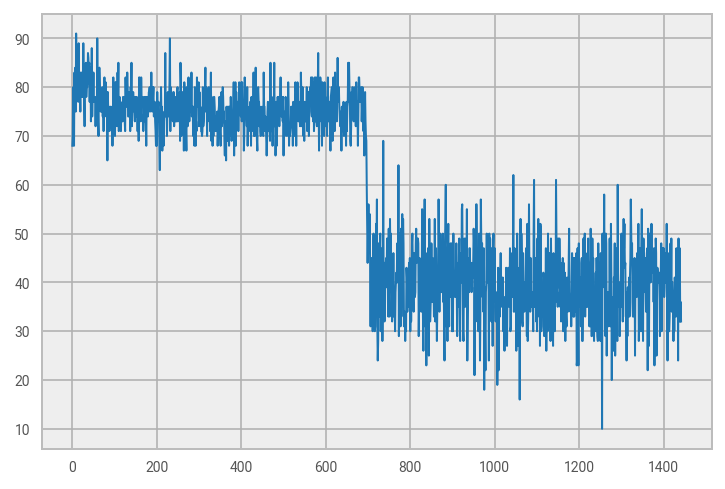

*************************************** Oliver ***********************************
48.0


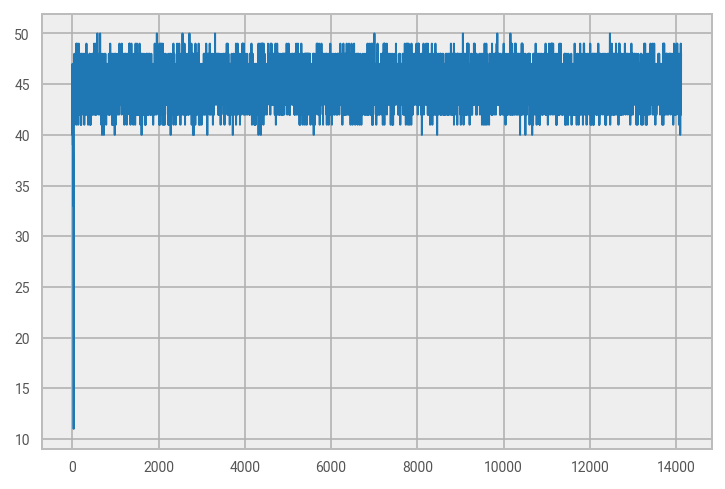

*************************************** Nicholas ***********************************
44.0


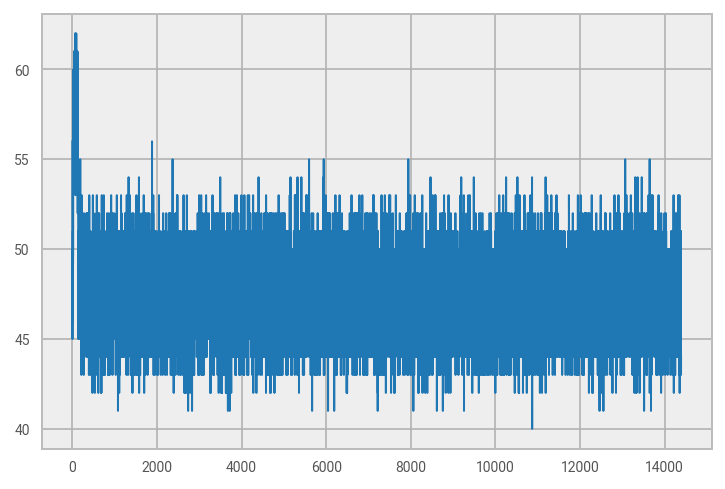

*************************************** Joshua ***********************************
48.0


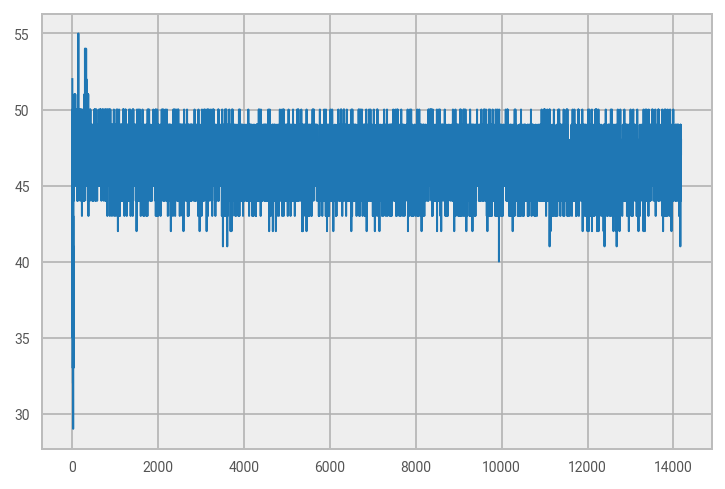

*************************************** Colton ***********************************
55.0


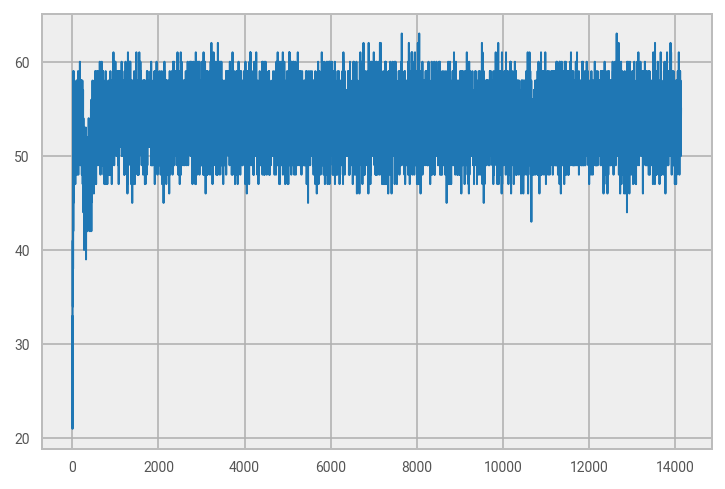

*************************************** Eli ***********************************
40.0


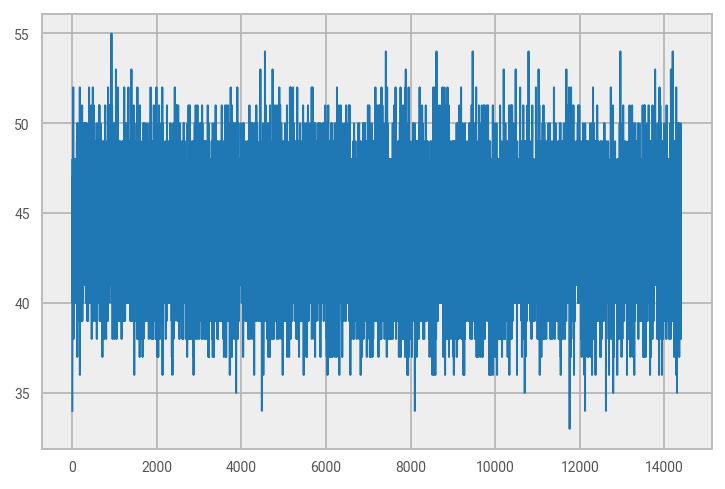

*************************************** Elijah ***********************************
77.0


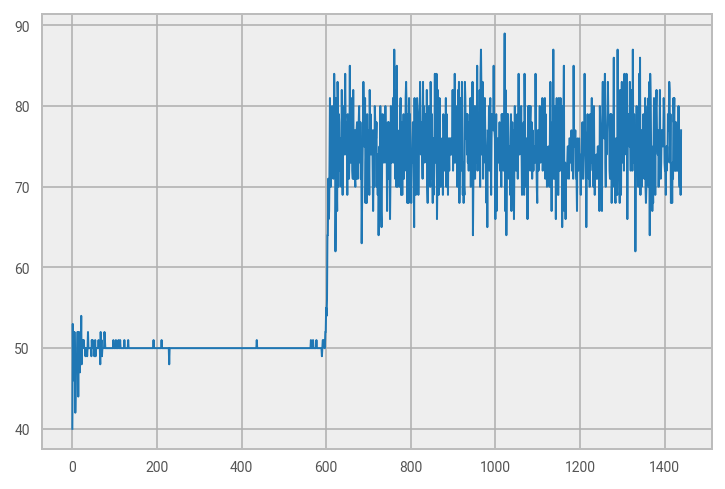

*************************************** Hudson ***********************************
53.0


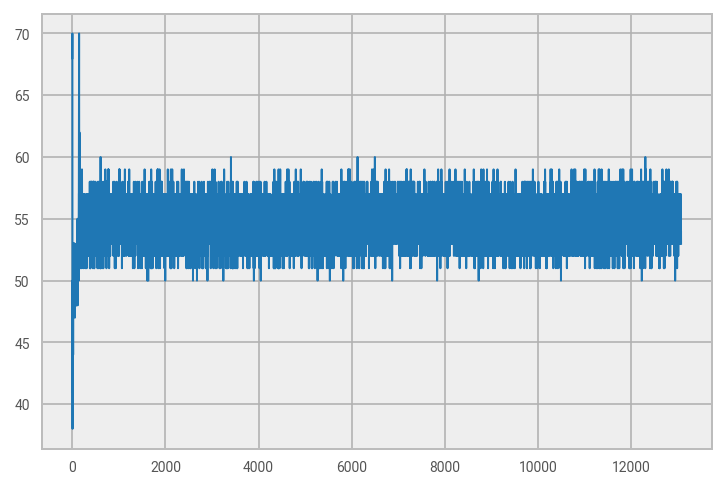

*************************************** Leo ***********************************
53.0


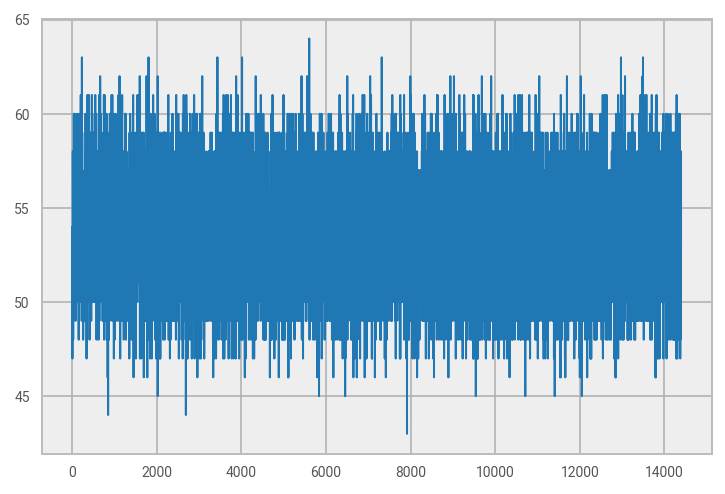

*************************************** Charles ***********************************
53.0


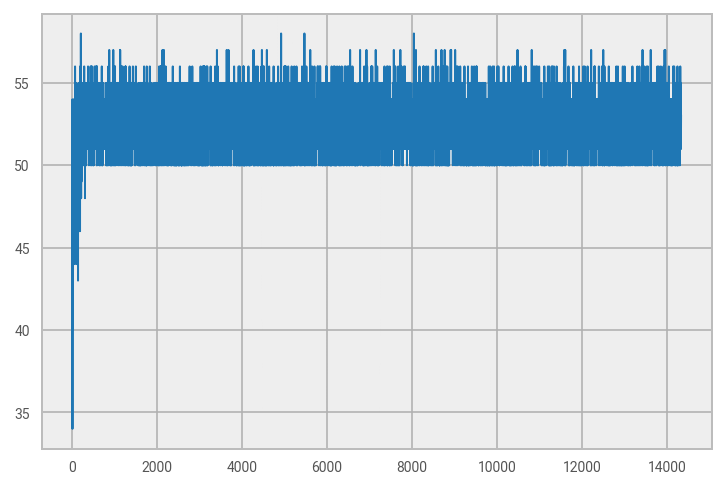

*************************************** Luke ***********************************
55.0


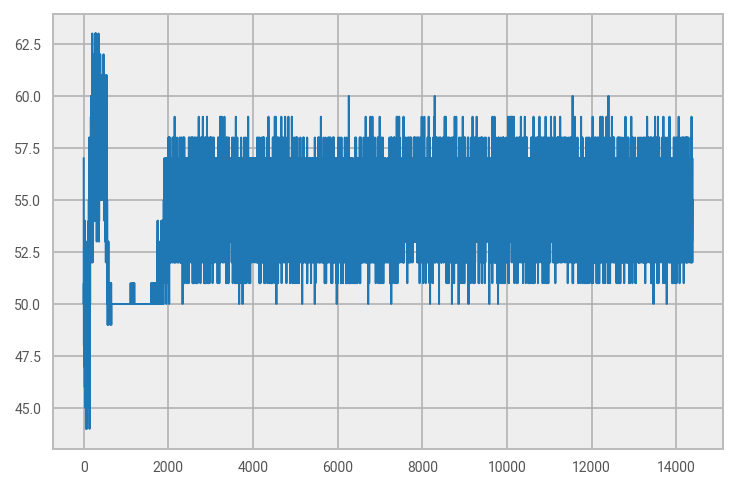

*************************************** Anthony ***********************************
47.0


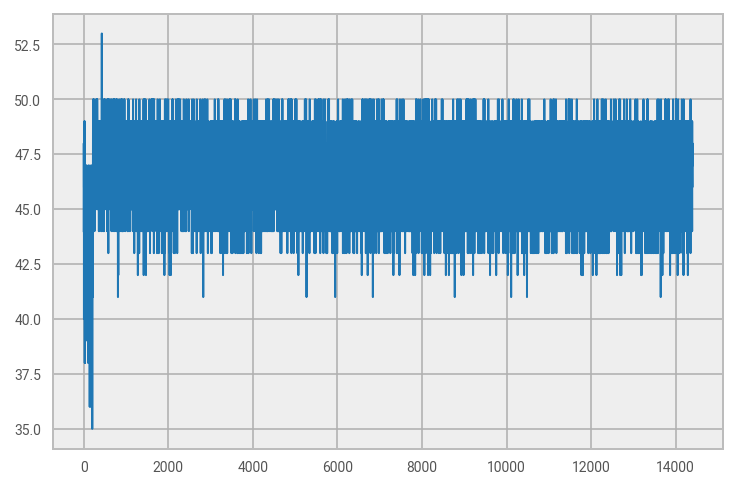

*************************************** Joseph ***********************************
50.0


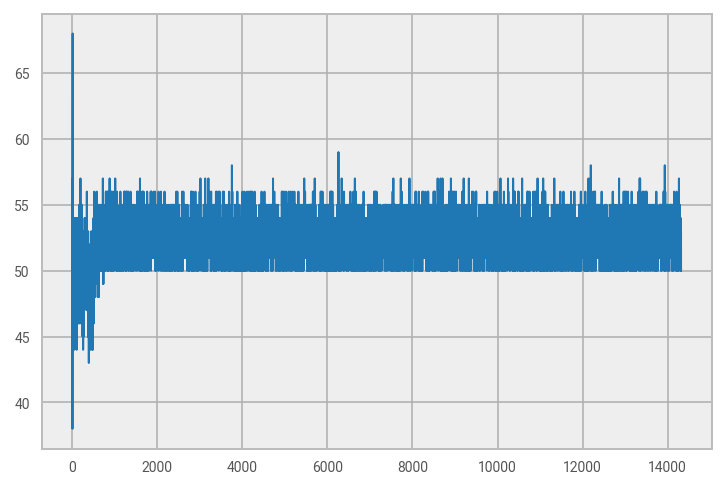

*************************************** Jeremiah ***********************************
55.0


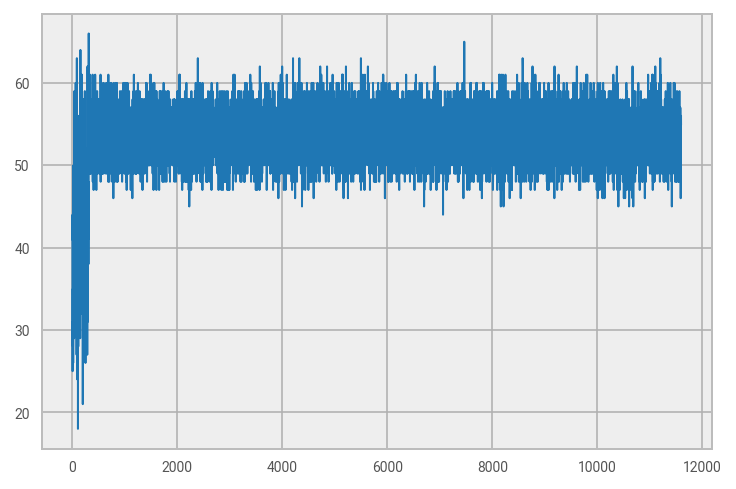

*************************************** Caleb ***********************************
57.0


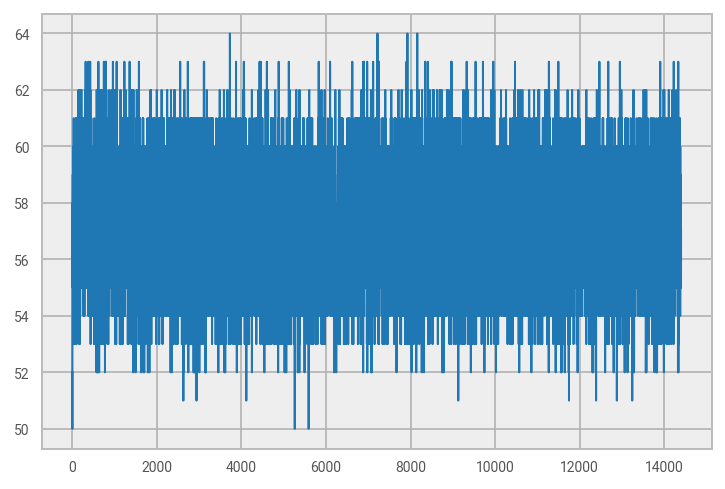

*************************************** Declan ***********************************
48.0


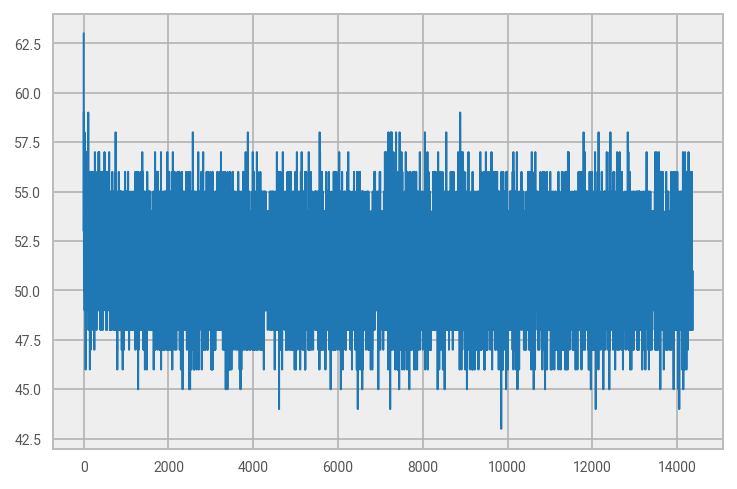

*************************************** Lucas ***********************************
46.0


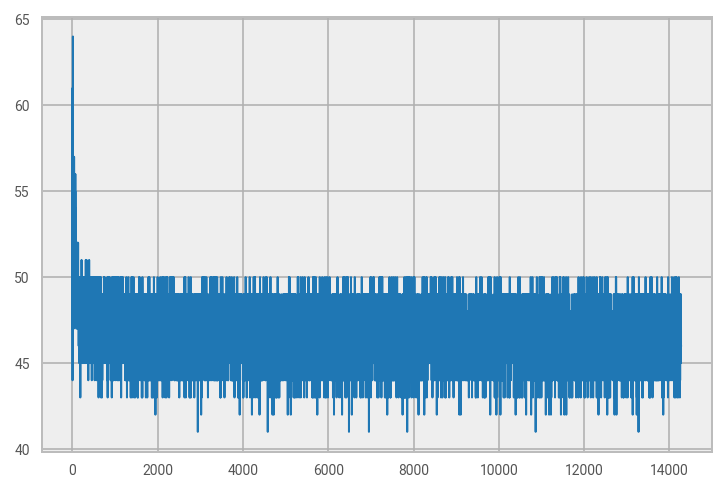

*************************************** Greyson ***********************************
52.0


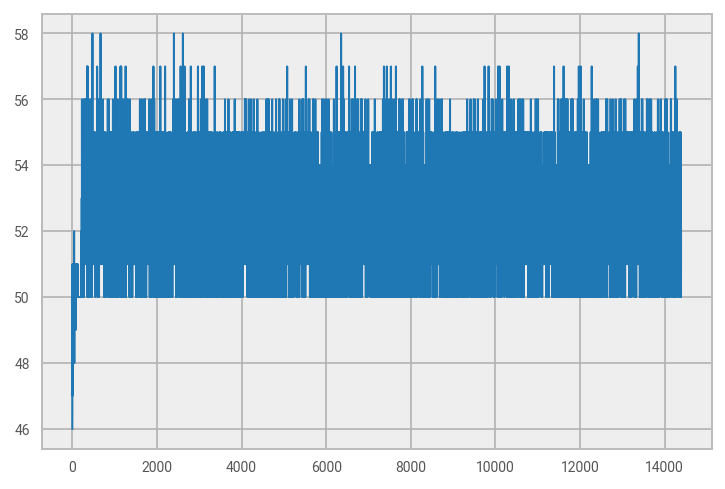

*************************************** Christian ***********************************
52.0


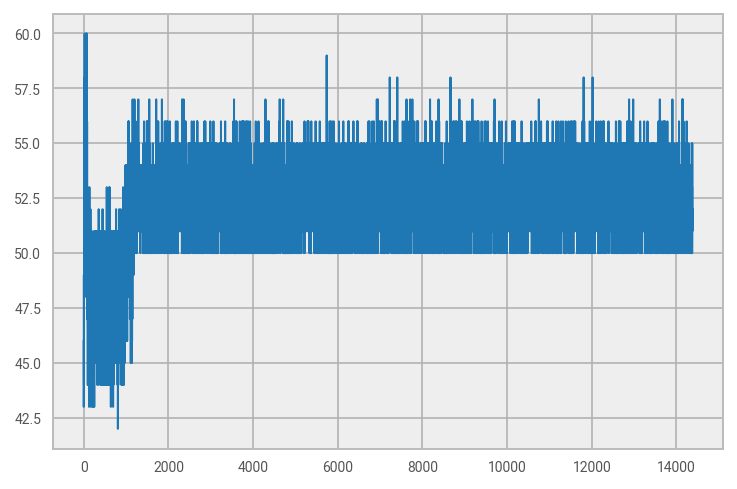

*************************************** Jayden ***********************************
56.0


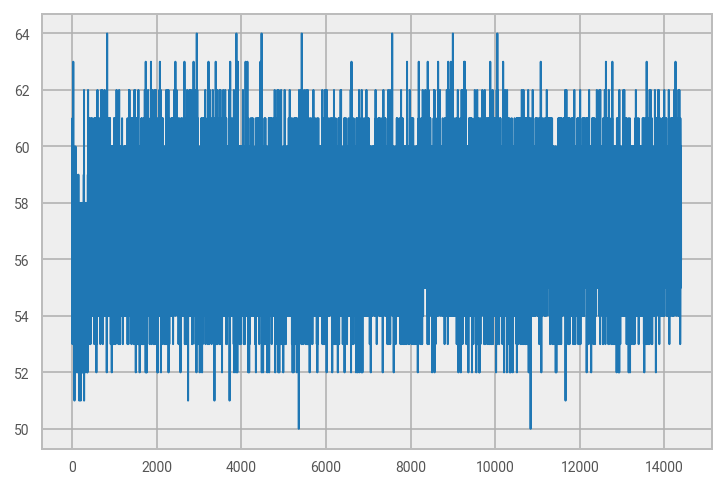

*************************************** Isaac ***********************************
42.0


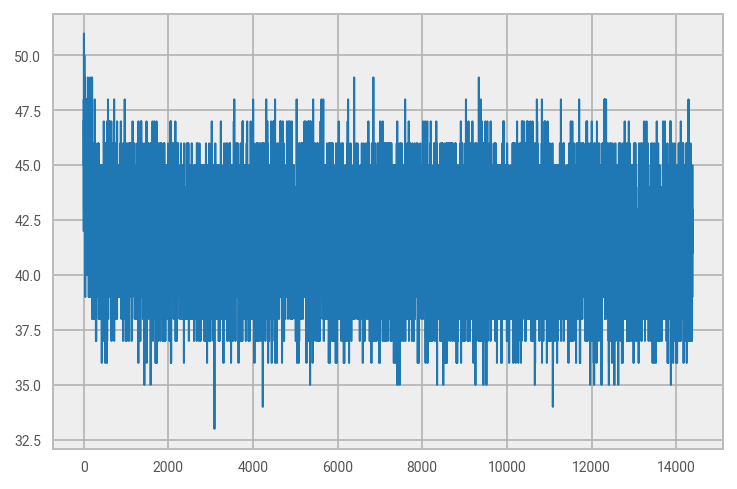

*************************************** John ***********************************
43.0


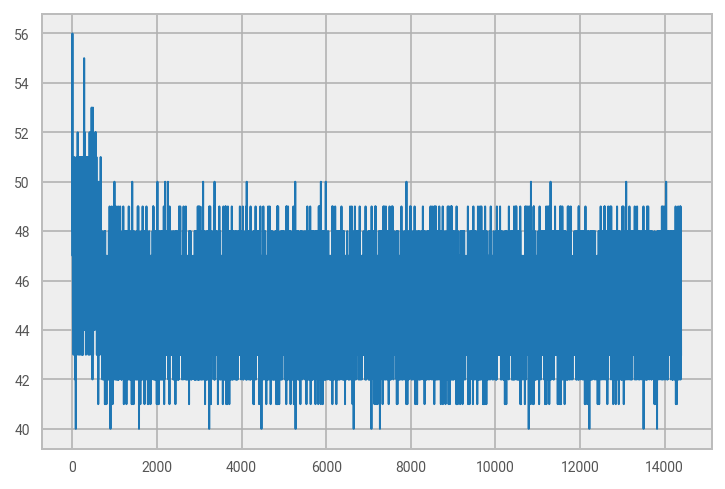

In [407]:
for i in people:
    print('***************************************',i,'***********************************')
    print(population[i].reward)
    plt.plot(population[i].all_rews)
    plt.show()

In [253]:
# from torch.multiprocessing import Pool

In [258]:
# def target_fn(pair):
#     interact(pair)

In [259]:
# def interact(pair):
#     entity_1 = population[pair[0]]
#     entity_2 = population[pair[1]]

#     entity_1.action(entity_2)
#     entity_2.action(entity_1)

#     if entity_1.alive == False:
#         entity_1.learn()
#     if entity_2.alive == False:
#         entity_2.learn()

In [269]:
# population = {i:Entity() for i in people}
# np.random.shuffle(people)
# pairs = list(zip(people[:50],people[50:]))

# #action = interact
# gens_rew = []
# pop_rews = {i:[] for i in people}
# for k in range(100):
#     t1 = time.time()
#     if k % 1000 == 0:
#         print('**************',k,'****************')
    
#     p = Pool(40)
#     p.map(target_fn,pairs)
#     p.close()
#     p.join()
#     t2 = time.time()
#     print(t2-t1)
#     gens_rew.append(np.mean(pop_rew))
#     np.random.shuffle(people)
#     pairs = list(zip(people[:50],people[50:]))

In [271]:
import sys